In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import solve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# === 1) Load & Bersihkan ===
df = pd.read_excel("Data pertandingan19-25.xlsx", sheet_name=0)
df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")], errors="ignore")

df["HomeTeam"] = df["HomeTeam"].astype(str).str.strip()
df["AwayTeam"] = df["AwayTeam"].astype(str).str.strip()

df.loc[df["HomeTeam"].str.lower().isin(["", "nan", "none"]), "HomeTeam"] = np.nan
df.loc[df["AwayTeam"].str.lower().isin(["", "nan", "none"]), "AwayTeam"] = np.nan
df = df.dropna(subset=["HomeTeam", "AwayTeam"]).reset_index(drop=True)

# === 2) Mapping tim ===
teams = sorted(pd.unique(pd.concat([df["HomeTeam"], df["AwayTeam"]], ignore_index=True)))
team_id = {team: i + 1 for i, team in enumerate(teams)}
df["HomeID"] = df["HomeTeam"].map(team_id).astype(int)
df["AwayID"] = df["AwayTeam"].map(team_id).astype(int)

# === 3) Feature engineering umum ===
df["GoalDiff"] = df["FTHG"] - df["FTAG"]
df["HomeShotAcc"] = df["HST"] / df["HS"].replace(0, 1)
df["AwayShotAcc"] = df["AST"] / df["AS"].replace(0, 1)
df["HomeDiscipline"] = (df["HY"] + 2 * df["HR"]) / df["HF"].replace(0, 1)
df["AwayDiscipline"] = (df["AY"] + 2 * df["AR"]) / df["AF"].replace(0, 1)

home_strength = df.groupby("HomeTeam")["FTHG"].mean()
away_strength = df.groupby("AwayTeam")["FTAG"].mean()
df["HomeStrength"] = df["HomeTeam"].map(home_strength)
df["AwayStrength"] = df["AwayTeam"].map(away_strength)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Season"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# === 4) Model Full-Time ===
numeric_cols = [
    "FTHG", "FTAG", "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR", "HomeID", "AwayID",
    "GoalDiff", "HomeShotAcc", "AwayShotAcc",
    "HomeDiscipline", "AwayDiscipline",
    "HomeStrength", "AwayStrength", "Season", "Month"
]
df_full = df[numeric_cols].copy()

target_home, target_away = "FTHG", "FTAG"
predictors = [c for c in df_full.columns if c not in [target_home, target_away]]

X = df_full[predictors].values
y_home = df_full[target_home].values
y_away = df_full[target_away].values

X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

def nb2_fit(X, y, alpha=1.0, max_iter=200, tol=1e-8):
    X = np.column_stack([np.ones(len(X)), X])
    Z0 = np.log(y + 1.0)
    beta = solve(X.T @ X, X.T @ Z0)

    for t in range(max_iter):
        eta = X @ beta
        mu = np.exp(eta)
        mu = np.clip(mu, 1e-12, None)
        w = mu / (1.0 + alpha * mu)
        z = eta + (y - mu) / mu
        WX = w[:, None] * X
        H = X.T @ WX
        U = X.T @ (w * (z - eta))
        delta = solve(H, U)
        beta += delta
        if np.max(np.abs(delta)) < tol:
            break
    return beta

print("\n🔸 Fitting Model Full-Time (FTHG)")
beta_home = nb2_fit(X_train, y_train_home)
print("✅ Selesai NBR Home")

print("\n🔸 Fitting Model Full-Time (FTAG)")
beta_away = nb2_fit(X_train, y_train_away)
print("✅ Selesai NBR Away")

# === 5) Model Half-Time ===
numeric_cols_ht = [
    "HTHG", "HTAG", "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR", "HomeID", "AwayID",
    "HomeShotAcc", "AwayShotAcc", "HomeDiscipline", "AwayDiscipline",
    "HomeStrength", "AwayStrength", "Season", "Month"
]
df_ht = df[numeric_cols_ht].copy()

target_ht_home, target_ht_away = "HTHG", "HTAG"
predictors_ht = [c for c in df_ht.columns if c not in [target_ht_home, target_ht_away]]

X_ht = df_ht[predictors_ht].values
y_ht_home = df_ht[target_ht_home].values
y_ht_away = df_ht[target_ht_away].values

Xht_train, Xht_test, yht_train_home, yht_test_home = train_test_split(X_ht, y_ht_home, test_size=0.2, random_state=42)
_, _, yht_train_away, yht_test_away = train_test_split(X_ht, y_ht_away, test_size=0.2, random_state=42)

print("\n🔸 Fitting Model Half-Time (HTHG)")
beta_ht_home = nb2_fit(Xht_train, yht_train_home)
print("✅ Selesai NBR Half-Time Home")

print("\n🔸 Fitting Model Half-Time (HTAG)")
beta_ht_away = nb2_fit(Xht_train, yht_train_away)
print("✅ Selesai NBR Half-Time Away")

# === 6) Simpan Model Gabungan ===
data_bundle = {
    "beta_home": beta_home,
    "beta_away": beta_away,
    "beta_ht_home": beta_ht_home,
    "beta_ht_away": beta_ht_away,
    "predictors": predictors,
    "predictors_ht": predictors_ht,
    "team_id": team_id,
}

with open("nbr_model.pkl", "wb") as f:
    pickle.dump(data_bundle, f)

print("\n✅ Model NBR (Full + HT) disimpan ke 'nbr_model.pkl'")


C:\Users\aldoh\AppData\Local\Temp\ipykernel_13460\1843449283.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")



🔸 Fitting Model Full-Time (FTHG)
✅ Selesai NBR Home

🔸 Fitting Model Full-Time (FTAG)
✅ Selesai NBR Away

🔸 Fitting Model Half-Time (HTHG)
✅ Selesai NBR Half-Time Home

🔸 Fitting Model Half-Time (HTAG)
✅ Selesai NBR Half-Time Away

✅ Model NBR (Full + HT) disimpan ke 'nbr_model.pkl'


In [2]:
# 1. Goal Difference
df["GoalDiff"] = df["FTHG"] - df["FTAG"]

# 2. Shot Accuracy
df["HomeShotAcc"] = df["HST"] / df["HS"].replace(0, 1)
df["AwayShotAcc"] = df["AST"] / df["AS"].replace(0, 1)

# 3. Discipline Index
df["HomeDiscipline"] = (df["HY"] + 2*df["HR"]) / df["HF"].replace(0, 1)
df["AwayDiscipline"] = (df["AY"] + 2*df["AR"]) / df["AF"].replace(0, 1)

# 4. Home/Away Strength (mean goals historically)
home_strength = df.groupby("HomeTeam")["FTHG"].mean()
away_strength = df.groupby("AwayTeam")["FTAG"].mean()
df["HomeStrength"] = df["HomeTeam"].map(home_strength)
df["AwayStrength"] = df["AwayTeam"].map(away_strength)

# 5. Time-based features
df["Season"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# === 11. Gabungkan fitur hasil feature engineering ke df_model tanpa double ===
feature_cols = [
    "GoalDiff", "HomeShotAcc", "AwayShotAcc",
    "HomeDiscipline", "AwayDiscipline",
    "HomeStrength", "AwayStrength",
    "Season", "Month"
]

for col in feature_cols:
    df_model[col] = df[col]

# hapus duplikat kolom kalau masih ada
df_model = df_model.loc[:, ~df_model.columns.duplicated()]
# simpan hasil akhir
df_model.to_excel(
    r"C:\Users\aldoh\Downloads\setelah_preprocess_feature2.xlsx",
    index=False,
    sheet_name="Pertandingan"
)

print("✅ Dataset final siap untuk NBR (tanpa kolom double)")
print("Jumlah kolom total:", df_model.shape[1])

NameError: name 'df_model' is not defined

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import solve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle



# =========================================================
# 0) Utilitas
# =========================================================
def safe_log(x, eps=1e-12):
    return np.log(np.clip(x, eps, None))

def nb2_deviance(y, mu, alpha, eps=1e-12):
    """
    Deviance Negative Binomial (NB2): var = mu + alpha * mu^2
    D = 2 * sum( y*log(y/mu) - (1/alpha)*log((1+alpha*y)/(1+alpha*mu)) )
    """
    y = np.asarray(y, dtype=float)
    mu = np.asarray(mu, dtype=float)
    mu = np.clip(mu, eps, None)
    ay = 1.0 + alpha * y
    am = 1.0 + alpha * mu
    term1 = np.where(y > 0, y * (safe_log(y) - safe_log(mu)), 0.0)
    term2 = (1.0 / alpha) * (safe_log(ay) - safe_log(am))
    return 2.0 * np.sum(term1 - term2)

def r2_score_manual(y, y_pred):
    y = np.asarray(y, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot

# =========================================================
# 1) Preprocessing ala BHM (tanpa struktur hierarki)
#    - alias kolom
#    - pastikan numeric
#    - scaling H*/A* terpisah
#    - persiapkan HomeID/AwayID
# =========================================================
FULL_UPPER = ["HST","AST","HS","AS","HC","AC","HY","AY","HR","AR"]
ALIAS = {
    "hst":"HST","ast":"AST","hs":"HS","aws":"AS","hc":"HC","ac":"AC",
    "hy":"HY","ay":"AY","hr":"HR","ar":"AR","hthg":"HTHG","htag":"HTAG"
}

def preprocess_for_nbr(df_raw):
    df = df_raw.copy()

    # drop kolom kosong
    df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")],
                 errors="ignore")

    # HomeID / AwayID
    col_home_id = "HomeID" if "HomeID" in df.columns else ("home_id" if "home_id" in df.columns else None)
    col_away_id = "AwayID" if "AwayID" in df.columns else ("away_id" if "away_id" in df.columns else None)
    if col_home_id is None or col_away_id is None:
        raise ValueError("Dataset harus punya kolom HomeID/AwayID (atau home_id/away_id).")

    df["HomeID"] = pd.to_numeric(df[col_home_id], errors="coerce").astype("Int64")
    df["AwayID"] = pd.to_numeric(df[col_away_id], errors="coerce").astype("Int64")

    # Goal kolom
    g_home_col = "FTHG" if "FTHG" in df.columns else ("fthg" if "fthg" in df.columns else None)
    g_away_col = "FTAG" if "FTAG" in df.columns else ("ftag" if "ftag" in df.columns else None)
    if g_home_col is None or g_away_col is None:
        raise ValueError("Butuh kolom FTHG/FTAG (atau fthg/ftag).")

    df["FTHG"] = pd.to_numeric(df[g_home_col], errors="coerce")
    df["FTAG"] = pd.to_numeric(df[g_away_col], errors="coerce")

    # alias low→UPPER
    for low, up in ALIAS.items():
        if low in df.columns and up not in df.columns:
            df[up] = pd.to_numeric(df[low], errors="coerce").fillna(0)

    # pastikan semua FULL_UPPER numeric
    for c in FULL_UPPER + ["HTHG","HTAG"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # drop rows NA id/goals
    df = df.loc[df["HomeID"].notna() & df["AwayID"].notna() & df["FTHG"].notna() & df["FTAG"].notna()].copy()
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)

    return df

# =========================================================
# 2) Bangun Team Strength (dari TRAIN SAJA, anti-leakage)
#    Versi sederhana: ridge kecil pada sistem linear
#    Menghasilkan rating per tim (attack - defense) → fitur
# =========================================================
def build_team_strength_simple(df_train, lambda_ridge=1e-2):
    """
    Hitung rating tim berbasis data TRAIN:
    Dengan ridge + lstsq (agar tidak error Singular Matrix)
    """
    hids = df_train["HomeID"].values
    aids = df_train["AwayID"].values
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)
    id2idx = {tid: i for i, tid in enumerate(teams)}

    # Sistem 2 persamaan per match
    p = 1 + n + n       # bias + attack + defense
    m = len(df_train) * 2
    X = np.zeros((m, p))
    y = np.zeros(m)

    r = 0
    for _, row in df_train.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]

        # FTHG ≈ b + att[hi] - def[ai]
        X[r, 0] = 1.0
        X[r, 1+hi] = 1.0
        X[r, 1+n+ai] = -1.0
        y[r] = row["FTHG"]
        r += 1

        # FTAG ≈ b + att[ai] - def[hi]
        X[r, 0] = 1.0
        X[r, 1+ai] = 1.0
        X[r, 1+n+hi] = -1.0
        y[r] = row["FTAG"]
        r += 1

    # Ridge + least-squares
    A = X.T @ X + lambda_ridge * np.eye(p)
    b = X.T @ y
    coef, *_ = np.linalg.lstsq(A, b, rcond=None)

    bias = coef[0]
    att = coef[1:1+n]
    dff = coef[1+n:]

    rating = att - dff
    rating = rating - rating.mean()  # center

    idx2id = {i: t for t, i in id2idx.items()}
    ratings = {idx2id[i]: float(rating[i]) for i in range(n)}

    return ratings, float(bias)


# =========================================================
# 3) Siapkan fitur akhir untuk NBR
#    - fitur dasar (HST/AST/HS/AS/HC/AC/HY/AY/HR/AR)
#    - + team strength (HomeStrength, AwayStrength, StrengthDiff)
#    - scaling fitur numerik (fit di TRAIN, transform ke TEST)
# =========================================================
from sklearn.preprocessing import StandardScaler

def build_features_with_strength(df_train, df_test):
    # pilih fitur dasar yang tersedia
    base_H = [c for c in ["HST","HS","HC","HY","HR"] if c in df_train.columns]
    base_A = [c for c in ["AST","AS","AC","AY","AR"] if c in df_train.columns]

    # hitung strength dari TRAIN
    ratings, _ = build_team_strength_simple(df_train)

    def add_strength_cols(df):
        hs = df["HomeID"].map(ratings).fillna(0.0)
        as_ = df["AwayID"].map(ratings).fillna(0.0)
        df = df.copy()
        df["HomeStrength"] = hs
        df["AwayStrength"] = as_
        df["StrengthDiff"] = hs - as_
        return df

    df_train2 = add_strength_cols(df_train)
    df_test2  = add_strength_cols(df_test)

    # gabungan fitur akhir
    feat_cols = base_H + base_A + ["HomeStrength","AwayStrength","StrengthDiff"]

    # scaling fit H/A + strength sekaligus (fit di TRAIN saja)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train2[feat_cols].values)
    X_test  = scaler.transform(df_test2[feat_cols].values)

    return X_train, X_test, feat_cols, df_train2, df_test2

# =========================================================
# 4) Fit NBR (NB2) via IRLS + grid alpha
# =========================================================
def nb2_fit(X, y, alpha=1.0, max_iter=200, tol=1e-8):
    X = np.asarray(X, dtype=float); y = np.asarray(y, dtype=float)
    X_ = np.column_stack([np.ones(len(X)), X])

    # init beta via OLS pada log(y+1)
    Z0 = np.log(y + 1.0)
    A = X_.T @ X_ + 1e-6*np.eye(X_.shape[1])  # ridge kecil
    b = X_.T @ Z0
    beta, *_ = np.linalg.lstsq(A, b, rcond=None)


    def irls_step(Xi, yi, beta_current, alpha_):
        eta = Xi @ beta_current
        mu = np.exp(eta)
        mu = np.clip(mu, 1e-12, None)
        w = mu / (1.0 + alpha_ * mu)
        z = eta + (yi - mu) / mu
        WX = w[:, None] * Xi
        H = Xi.T @ WX
        U = Xi.T @ (w * (z - eta))
        delta, *_ = np.linalg.lstsq(H + 1e-6*np.eye(H.shape[0]), U, rcond=None)
        return beta_current + delta, delta

    for _ in range(max_iter):
        beta_new, delta = irls_step(X_, y, beta, alpha)
        beta = beta_new
        if np.max(np.abs(delta)) < tol:
            break
    return beta

def fit_nb2_with_alpha_grid(X, y, alphas=(0.05, 0.1, 0.2, 0.5, 1.0)):
    best = (None, None, np.inf)
    Xc = np.column_stack([np.ones(len(X)), X])
    for a in alphas:
        beta = nb2_fit(X, y, alpha=a)
        mu_hat = np.exp(Xc @ beta)
        D = nb2_deviance(y, mu_hat, alpha=a)
        if D < best[2]:
            best = (beta, a, D)
    return best  # (beta, alpha, dev_train)

# =========================================================
# 5) MAIN: Load, preprocess, split, build features, train, evaluate
# =========================================================
# Ganti path sesuai file kamu:
DATA_PATH = "Data pertandingan19-25.xlsx"  
df_raw = pd.read_excel(DATA_PATH, sheet_name=0)
df = preprocess_for_nbr(df_raw)

# train-test split konsisten untuk home/away
TEST_SIZE = 0.2      # 0.2 = 80-20 ; 0.3 = 70-30
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42)

# siapkan fitur (termasuk strength dari TRAIN)
X_train, X_test, feat_cols, df_train2, df_test2 = build_features_with_strength(df_train, df_test)

y_train_home = df_train2["FTHG"].values.astype(float)
y_train_away = df_train2["FTAG"].values.astype(float)
y_test_home  = df_test2["FTHG"].values.astype(float)
y_test_away  = df_test2["FTAG"].values.astype(float)

# train dua model: home & away
beta_home, alpha_home, dev_tr_home = fit_nb2_with_alpha_grid(X_train, y_train_home)
beta_away, alpha_away, dev_tr_away = fit_nb2_with_alpha_grid(X_train, y_train_away)
print(f"Alpha HOME: {alpha_home} | Dev-train HOME: {dev_tr_home:.2f}")
print(f"Alpha AWAY: {alpha_away} | Dev-train AWAY: {dev_tr_away:.2f}")

# prediksi test
X_test_const = np.column_stack([np.ones(len(X_test)), X_test])
mu_hat_home = np.exp(X_test_const @ beta_home)
mu_hat_away = np.exp(X_test_const @ beta_away)

y_hat_home = np.clip(np.rint(mu_hat_home), 0, None).astype(int)
y_hat_away = np.clip(np.rint(mu_hat_away), 0, None).astype(int)

# evaluasi selisih (fokus kamu)
gd_actual   = y_test_home - y_test_away
gd_pred_mu  = mu_hat_home - mu_hat_away
gd_pred_int = y_hat_home  - y_hat_away

gd_abs_actual   = np.abs(gd_actual)
gd_abs_pred_mu  = np.abs(gd_pred_mu)
gd_abs_pred_int = np.abs(gd_pred_int)

mae_gd_abs_mu  = mean_absolute_error(gd_abs_actual, gd_abs_pred_mu)
rmse_gd_abs_mu = np.sqrt(mean_squared_error(gd_abs_actual, gd_abs_pred_mu))
mae_gd_abs_int = mean_absolute_error(gd_abs_actual, gd_abs_pred_int)
rmse_gd_abs_int= np.sqrt(mean_squared_error(gd_abs_actual, gd_abs_pred_int))

print("\n=== Evaluasi |GD| (Absolute Selisih) ===")
print(f"MAE |GD| (mean): {mae_gd_abs_mu:.4f}")
print(f"RMSE|GD| (mean): {rmse_gd_abs_mu:.4f}")
print(f"MAE |GD| (int) : {mae_gd_abs_int:.4f}")
print(f"RMSE|GD| (int) : {rmse_gd_abs_int:.4f}")

# R² (tambahan)
r2_home = r2_score_manual(y_test_home, mu_hat_home)
r2_away = r2_score_manual(y_test_away, mu_hat_away)
r2_gd   = r2_score_manual(gd_actual, gd_pred_mu)
print("\n=== R² ===")
print(f"R² Home : {r2_home:.4f}")
print(f"R² Away : {r2_away:.4f}")
print(f"R² GD   : {r2_gd:.4f}")

# Deviance test
dev_test_home = nb2_deviance(y_test_home, mu_hat_home, alpha_home)
dev_test_away = nb2_deviance(y_test_away, mu_hat_away, alpha_away)
print("\n=== Deviance (test) ===")
print(f"Dev HOME: {dev_test_home:.2f} | alpha={alpha_home}")
print(f"Dev AWAY: {dev_test_away:.2f} | alpha={alpha_away}")
print(f"Dev TOTAL: {dev_test_home + dev_test_away:.2f}")

# preview
preview = pd.DataFrame({
    "FTHG_actual": y_test_home[:15],
    "FTAG_actual": y_test_away[:15],
    "FTHG_pred_mu": mu_hat_home[:15],
    "FTAG_pred_mu": mu_hat_away[:15],
    "GD_actual": gd_actual[:15],
    "GD_pred_mu": gd_pred_mu[:15],
    "|GD|_actual": gd_abs_actual[:15],
    "|GD|_pred_mu": gd_abs_pred_mu[:15],
})
print("\nPreview (15 baris):")
print(preview)

# =========================================================
# 6) Fungsi Prediksi Pre-Match & Real-Time (pakai strength)
# =========================================================
# simpan scaler & kolom fitur supaya bisa prediksi baris tunggal
# (di sini kita tidak simpan scaler; kalau butuh API produksi, simpan objeknya)
# Untuk contoh sederhana, kita akan rebuild fitur dari df_train + ratings train.

# Build kembali komponen prediktor sekali, untuk pemanggilan satu baris:
_ratings_train, _ = build_team_strength_simple(df_train)

def _vectorize_row(row, feat_cols, ratings):
    """Bangun vektor fitur untuk satu baris (menggunakan kolom yang sudah disiapkan)."""
    # fitur dasar
    feats = []
    for c in ["HST","HS","HC","HY","HR"]:
        feats.append(row.get(c, 0.0))
    for c in ["AST","AS","AC","AY","AR"]:
        feats.append(row.get(c, 0.0))
    # strength
    hs = ratings.get(int(row["HomeID"]), 0.0)
    as_ = ratings.get(int(row["AwayID"]), 0.0)
    feats += [hs, as_, hs - as_]
    return np.array(feats, dtype=float)

# untuk konsistensi skala, kita pinjam scaler yang fit di TRAIN:
# (kita buat ulang scaler dari TRAIN agar vektor single row ikut standardisasi yang sama)
_sclr = StandardScaler()
_tmp_train_matrix = np.column_stack([
    df_train2[[c for c in ["HST","HS","HC","HY","HR"] if c in df_train2.columns]].reindex(columns=["HST","HS","HC","HY","HR"], fill_value=0).values,
    df_train2[[c for c in ["AST","AS","AC","AY","AR"] if c in df_train2.columns]].reindex(columns=["AST","AS","AC","AY","AR"], fill_value=0).values,
    df_train2[["HomeStrength","AwayStrength","StrengthDiff"]].values
])
_sclr.fit(_tmp_train_matrix)

def _standardize_vec(vec):
    return _sclr.transform(vec.reshape(1, -1)).ravel()

def predict_prematch_by_ids(df_source, home_id, away_id, beta_home, beta_away):
    """
    Prediksi pre-match untuk sepasang (home_id, away_id) dari satu baris referensi di df_source.
    Catatan: df_source harus mengandung kolom fitur numerik H*/A* untuk baris tersebut.
    """
    # ambil satu baris yang representatif (mis. baris terakhir kedua tim bertemu atau baris home team terbaru)
    # agar contoh jalan, kita ambil baris pertama yang match dengan pasangan ini;
    # di produksi sebaiknya kamu pilih strategi sampling yang konsisten.
    row = df_source[(df_source["HomeID"]==home_id) & (df_source["AwayID"]==away_id)]
    if len(row)==0:
        # fallback: pakai baris home_id apapun vs lawan lain (terbaru) untuk ambil fitur dasar
        row = df_source[df_source["HomeID"]==home_id].tail(1)
        if len(row)==0:
            # fallback lain: pakai baris away_id sebagai acuan dan tukar sisi
            row = df_source[df_source["AwayID"]==away_id].tail(1)
            if len(row)==0:
                raise ValueError("Tidak ditemukan baris referensi yang cocok untuk membangun fitur tunggal.")
            # Jika dari sisi away, kita tetap bisa pakai nilai kolom A* dan set nilai H* ke nol jika tidak ada
    row = row.iloc[0].to_dict()

    vec = _vectorize_row(row, feat_cols, _ratings_train)
    vec_std = _standardize_vec(vec)
    Xc = np.concatenate([[1.0], vec_std])  # + intercept

    mu_home = float(np.exp(Xc @ beta_home))
    mu_away = float(np.exp(Xc @ beta_away))

    return {
        "home_id": int(home_id),
        "away_id": int(away_id),
        "mu_home": mu_home,
        "mu_away": mu_away,
        "pred_int_home": int(round(mu_home)),
        "pred_int_away": int(round(mu_away)),
        "pred_gd_mean": mu_home - mu_away,
        "pred_gd_int": int(round(mu_home - mu_away))
    }

def predict_realtime(mu_home_full, mu_away_full, HTHG, HTAG):
    """
    Prediksi waktu nyata (halftime):
      final_home = HTHG + max(mu_home_full - HTHG, 0)
      final_away = HTAG + max(mu_away_full - HTAG, 0)
    """
    rem_home = max(mu_home_full - HTHG, 0)
    rem_away = max(mu_away_full - HTAG, 0)
    final_home = HTHG + rem_home
    final_away = HTAG + rem_away
    return {
        "final_home_mean": float(final_home),
        "final_away_mean": float(final_away),
        "final_home_int": int(round(final_home)),
        "final_away_int": int(round(final_away)),
        "final_gd_mean": float(final_home - final_away),
        "final_gd_int": int(round(final_home - final_away))
    }

# =========================================================
# 7) Contoh pemanggilan pre-match & real-time
# =========================================================
# pilih contoh sepasang id yang ada di TEST
ex_row = df_test2.iloc[0]
example_home_id = int(ex_row["HomeID"])
example_away_id = int(ex_row["AwayID"])

print("\n--- PRE-MATCH PREDICT (contoh dari pasangan id di TEST) ---")
pm = predict_prematch_by_ids(df, example_home_id, example_away_id, beta_home, beta_away)
print(pm)

print("\n--- REAL-TIME PREDICT (misal HT 1-0) ---")
rt = predict_realtime(pm["mu_home"], pm["mu_away"], HTHG=1, HTAG=0)
print(rt)

# =========================================================
# 8) TEST BIASA — LANGSUNG SET home_id & away_id
# =========================================================

# 1) tentukan pasangan tim yang mau diprediksi
home_id = 1      # ← ganti sesuai yang kamu mau
away_id = 5     # ← ganti sesuai yang kamu mau

# 2) prediksi pre-match
hasil = predict_prematch_by_ids(df, home_id, away_id, beta_home, beta_away)

print("\n=== HASIL PRE-MATCH ===")
print(f"HomeID            : {hasil['home_id']}")
print(f"AwayID            : {hasil['away_id']}")
print(f"μ_home (mean)     : {hasil['mu_home']:.3f}")
print(f"μ_away (mean)     : {hasil['mu_away']:.3f}")
print(f"GoalDiff mean     : {hasil['pred_gd_mean']:.3f}")
print(f"Prediksi Skor Int : {hasil['pred_int_home']} - {hasil['pred_int_away']}")

# 3) contoh kalau ada skor HT:
HTHG = 1   # ubah kalau mau
HTAG = 0
hasil_ht = predict_realtime(hasil["mu_home"], hasil["mu_away"], HTHG, HTAG)

print("\n=== HASIL HALF-TIME (opsional) ===")
print(f"HT : {HTHG} - {HTAG}")
print(f"Pred Akhir mean : {hasil_ht['final_home_mean']:.3f} - {hasil_ht['final_away_mean']:.3f}")
print(f"Pred Akhir int  : {hasil_ht['final_home_int']} - {hasil_ht['final_away_int']}")
print(f"GD akhir int    : {hasil_ht['final_gd_int']}")

nbr_model = {
    "beta_home": beta_home,
    "beta_away": beta_away,
    "alpha_home": alpha_home,
    "alpha_away": alpha_away,
    "feat_cols": feat_cols,
    "ratings_train": _ratings_train,
    "scaler": _sclr,
}

with open("nbr_model.pkl", "wb") as f:
    pickle.dump(nbr_model, f)

print("✅ Model NBR berhasil disimpan → nbr_model.pkl")



Alpha HOME: 0.05 | Dev-train HOME: 1568.71
Alpha AWAY: 0.05 | Dev-train AWAY: 1574.22

=== Evaluasi |GD| (Absolute Selisih) ===
MAE |GD| (mean): 0.9149
RMSE|GD| (mean): 1.1949
MAE |GD| (int) : 0.9474
RMSE|GD| (int) : 1.2756

=== R² ===
R² Home : 0.2729
R² Away : 0.3245
R² GD   : 0.3410

=== Deviance (test) ===
Dev HOME: 407.64 | alpha=0.05
Dev AWAY: 364.18 | alpha=0.05
Dev TOTAL: 771.82

Preview (15 baris):
    FTHG_actual  FTAG_actual  FTHG_pred_mu  FTAG_pred_mu  GD_actual  \
0           0.0          3.0      0.668502      1.640699       -3.0   
1           0.0          1.0      0.802109      1.020577       -1.0   
2           1.0          3.0      2.898777      2.655374       -2.0   
3           0.0          4.0      1.124001      2.856291       -4.0   
4           0.0          1.0      0.751122      1.405740       -1.0   
5           0.0          4.0      0.714128      2.127492       -4.0   
6           1.0          0.0      0.764877      0.535890        1.0   
7           1.0      

In [82]:
z

NameError: name 'z' is not defined

In [86]:
import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ======================================================
# 1) PREPROCESS
# ======================================================
def preprocess_nbr(df):
    df = df.copy()
    df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")],
                 errors="ignore")

    # Kolom ID tim
    col_home_id = "HomeID" if "HomeID" in df.columns else "home_id"
    col_away_id = "AwayID" if "AwayID" in df.columns else "away_id"

    df["HomeID"] = pd.to_numeric(df[col_home_id], errors="coerce").astype("Int64")
    df["AwayID"] = pd.to_numeric(df[col_away_id], errors="coerce").astype("Int64")

    # Target gol
    g_home_col = "FTHG" if "FTHG" in df.columns else "fthg"
    g_away_col = "FTAG" if "FTAG" in df.columns else "ftag"
    df["FTHG"] = pd.to_numeric(df[g_home_col], errors="coerce")
    df["FTAG"] = pd.to_numeric(df[g_away_col], errors="coerce")

    # Alias fitur (sesuai BHM)
    alias = {
        "hst":"HST","ast":"AST","hs":"HS","aws":"AS","hc":"HC","ac":"AC",
        "hy":"HY","ay":"AY","hr":"HR","ar":"AR",
        "hthg":"HTHG","htag":"HTAG"
    }
    for low,up in alias.items():
        if low in df.columns and up not in df.columns:
            df[up] = df[low]

    for c in ["HST","HS","HC","HY","HR","AST","AS","AC","AY","AR","HTHG","HTAG"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)
    return df

    print("NBR TEAM IDS:", data["team_ids"])
    print("REQUEST:", home_id, away_id)


# ======================================================
# 2) BUILD TEAM STRENGTH (seperti BHM, tapi cepat)
# ======================================================
def build_team_strength(df):
    hids, aids = df["HomeID"].values, df["AwayID"].values
    teams = np.unique(np.concatenate([hids,aids]))
    n = len(teams)
    id2idx = {t:i for i,t in enumerate(teams)}

    p = 1 + n + n           # intercept + att + def
    m = len(df)*2
    X = np.zeros((m,p))
    y = np.zeros(m)

    r=0
    for _,row in df.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]
        # home goals
        X[r,0] = 1
        X[r,1+hi] = 1
        X[r,1+n+ai] = -1
        y[r] = row["FTHG"]
        r += 1
        # away goals
        X[r,0] = 1
        X[r,1+ai] = 1
        X[r,1+n+hi] = -1
        y[r] = row["FTAG"]
        r += 1

    A = X.T @ X + 1e-2*np.eye(p)
    b = X.T @ y
    coef,_ ,_,_ = lstsq(A,b,rcond=None)
    att = coef[1:1+n]
    dff = coef[1+n:]
    rating = att - dff
    rating = rating - rating.mean()          # zero-mean
    idx2id = {i:t for t,i in id2idx.items()}
    return {idx2id[i]:float(rating[i]) for i in range(n)}


# ======================================================
# 3) FIT NB2 via IRLS
# ======================================================
def nb2_fit(X, y, alpha=1.0, max_iter=200, tol=1e-8):
    X = np.asarray(X,float)
    y = np.asarray(y,float)
    X_ = np.column_stack([np.ones(len(X)), X])

    Z0 = np.log(y+1.0)
    A0 = X_.T @ X_ + 1e-6*np.eye(X_.shape[1])
    b0 = X_.T @ Z0
    beta, *_ = lstsq(A0,b0,rcond=None)

    for _ in range(max_iter):
        eta = X_ @ beta
        mu = np.exp(eta)
        mu = np.clip(mu,1e-12,None)
        w = mu / (1+alpha*mu)
        z = eta + (y - mu)/mu
        WX = w[:,None]*X_
        H = X_.T @ WX
        U = X_.T @ (w*(z - eta))
        Hreg = H + 1e-6*np.eye(H.shape[0])
        delta, *_ = lstsq(Hreg,U,rcond=None)
        beta_new = beta + delta
        if np.max(np.abs(delta))<tol:
            beta = beta_new
            break
        beta = beta_new
    return beta


# ======================================================
# 4) TRAINING
# ======================================================
df_raw = pd.read_excel("Data pertandingan19-25.xlsx",sheet_name=0)
df = preprocess_nbr(df_raw)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

ratings = build_team_strength(df_train)

feat_base_H = ["HST","HS","HC","HY","HR"]
feat_base_A = ["AST","AS","AC","AY","AR"]

df_train["HomeStrength"] = df_train["HomeID"].map(ratings)
df_train["AwayStrength"] = df_train["AwayID"].map(ratings)
df_train["StrengthDiff"] = df_train["HomeStrength"] - df_train["AwayStrength"]

feat_cols = feat_base_H + feat_base_A + ["HomeStrength","AwayStrength","StrengthDiff"]

scaler = StandardScaler()
X_tr = scaler.fit_transform(df_train[feat_cols].values)
y_tr_h = df_train["FTHG"].values
y_tr_a = df_train["FTAG"].values

beta_h = nb2_fit(X_tr,y_tr_h,alpha=0.1)
beta_a = nb2_fit(X_tr,y_tr_a,alpha=0.1)


# ======================================================
# 5) FUNGSI PREDIKSI FT
# ======================================================
def predict_nbr_ft(home_id, away_id, payload=None):
    if payload is None:
        payload = {}
    row = {}
    for c in feat_cols:
        row[c] = payload.get(c,0.0)  # default 0
    row["HomeStrength"] = ratings.get(home_id,0.0)
    row["AwayStrength"] = ratings.get(away_id,0.0)
    row["StrengthDiff"] = row["HomeStrength"] - row["AwayStrength"]

    x = np.array([row[c] for c in feat_cols],float).reshape(1,-1)
    x = scaler.transform(x).ravel()
    Xc = np.concatenate([[1.0],x])

    mu_h = float(np.exp(Xc @ beta_h))
    mu_a = float(np.exp(Xc @ beta_a))
    return {
        "home_id":home_id,
        "away_id":away_id,
        "mu_home":mu_h,
        "mu_away":mu_a,
        "pred_int_home":int(round(mu_h)),
        "pred_int_away":int(round(mu_a)),
        "pred_gd":mu_h - mu_a,
        "pred_gd_int":int(round(mu_h - mu_a)),
    }


# ======================================================
# 6) MODE HT
# ======================================================
def predict_nbr_ht(home_id, away_id, hthg, htag, payload=None):
    base = predict_nbr_ft(home_id,away_id,payload)
    lead = hthg - htag
    mu_h = base["mu_home"]
    mu_a = base["mu_away"]

    # logika lanjutan babak kedua
    if lead>0:      # unggul
        add_h = 0.30
        add_a = 0.70
    elif lead<0:    # tertinggal
        add_h = 0.70
        add_a = 0.30
    else:           # imbang
        add_h = 0.50
        add_a = 0.50

    # prediksi skor akhir
    ft_h = hthg + add_h*(mu_h/2)
    ft_a = htag + add_a*(mu_a/2)

    return {
        "home_id":home_id,
        "away_id":away_id,
        "ht_h":hthg,
        "ht_a":htag,
        "pred_final_home_mean":float(ft_h),
        "pred_final_away_mean":float(ft_a),
        "pred_final_home_int":int(round(ft_h)),
        "pred_final_away_int":int(round(ft_a)),
    }

res1 = predict_nbr_ft(1,21)
res2 = predict_nbr_ht(4,21, hthg=2, htag=1)

print("FT:", res1)
print("HT:", res2)


FT: {'home_id': 1, 'away_id': 21, 'mu_home': 0.9386932404375687, 'mu_away': 0.4936551892164552, 'pred_int_home': 1, 'pred_int_away': 0, 'pred_gd': 0.44503805122111356, 'pred_gd_int': 0}
HT: {'home_id': 4, 'away_id': 21, 'ht_h': 2, 'ht_a': 1, 'pred_final_home_mean': 2.1537233819764148, 'pred_final_away_mean': 1.1724909218024226, 'pred_final_home_int': 2, 'pred_final_away_int': 1}


In [30]:
model_data = {
    "beta_home": beta_home,
    "beta_away": beta_away,
    "alpha_home": alpha_home,
    "alpha_away": alpha_away,
    "predictors": predictors,
    "scaler": scaler,
    "df": df[["HomeID", "AwayID"] + predictors],   # ← WAJIB
}

import pickle
with open("nbr_model.pkl", "wb") as f:
    pickle.dump(model_data, f)


KeyError: "['GoalDiff', 'HomeShotAcc', 'AwayShotAcc', 'HomeDiscipline', 'AwayDiscipline', 'HomeStrength', 'AwayStrength', 'Season', 'Month'] not in index"

In [31]:
print(df.columns)


Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'away_id', 'home_id', 'HomeID', 'AwayID'],
      dtype='object')


In [52]:
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
from sklearn.preprocessing import StandardScaler
import pickle

# ======================================================
# 1) LOAD
# ======================================================
df = pd.read_excel("Data pertandingan19-25.xlsx")

# Normalisasi
cols = [c.lower() for c in df.columns]
df.columns = cols

df["HomeID"] = df["homeid"] if "homeid" in df else df["home_id"]
df["AwayID"] = df["awayid"] if "awayid" in df else df["away_id"]

df["FTHG"] = df["fthg"]
df["FTAG"] = df["ftag"]

df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
df["HomeID"] = df["HomeID"].astype(int)
df["AwayID"] = df["AwayID"].astype(int)

# ======================================================
# 2) BUILD SIMPLE RATING (attack-defense)
# ======================================================
teams = sorted(df["HomeID"].unique())
id2idx = {tid:i for i,tid in enumerate(teams)}
n = len(teams)

p = 1 + n + n
m = len(df)*2
X = np.zeros((m,p))
y = np.zeros(m)

r = 0
for _,row in df.iterrows():
    hi = id2idx[row["HomeID"]]
    ai = id2idx[row["AwayID"]]

    # home
    X[r,0]     = 1
    X[r,1+hi]  = 1
    X[r,1+n+ai] = -1
    y[r] = row["FTHG"]
    r+=1

    # away
    X[r,0]     = 1
    X[r,1+ai]  = 1
    X[r,1+n+hi] = -1
    y[r] = row["FTAG"]
    r+=1

A = X.T @ X + 1e-2*np.eye(p)
b = X.T @ y
coef,_ ,_,_ = lstsq(A,b,rcond=None)

att = coef[1:1+n]
dff = coef[1+n:]
rating = att - dff
rating = rating - rating.mean()

rating_map = {tid:float(rating[id2idx[tid]]) for tid in teams}

# ======================================================
# 3) FIT NB2 dengan *hanya* strengthDiff
# ======================================================
df["StrengthDiff"] = df["HomeID"].map(rating_map) - df["AwayID"].map(rating_map)

X = df[["StrengthDiff"]].values
yH = df["FTHG"].values
yA = df["FTAG"].values

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

def nb2_fit_simple(X,y,alpha=0.1):
    X_ = np.column_stack([np.ones(len(X)), X])
    eta = np.log(y + 1)
    beta, *_ = lstsq(X_.T @ X_ + 1e-4*np.eye(X_.shape[1]),
                     X_.T @ eta, rcond=None)
    return beta

beta_home = nb2_fit_simple(X_sc,yH)
beta_away = nb2_fit_simple(X_sc,yA)

# ======================================================
# 4) SAVE
# ======================================================
save = {
    "rating": rating_map,
    "beta_home": beta_home,
    "beta_away": beta_away,
    "scaler": scaler,
}

with open("nbr_model.pkl","wb") as f:
    pickle.dump(save,f)

print("✅ DONE — nbr_model.pkl saved")


✅ DONE — nbr_model.pkl saved


In [67]:
# ============================================================
# NBR — Prediksi Selisih Gol berbasis Team Strength
# Notebook berdiri sendiri, tidak butuh trace_full BHM
# ============================================================

import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# ------------------------------------------------------------
# 1) Load Data
# ------------------------------------------------------------
df = pd.read_excel("Data pertandingan19-25.xlsx")

# Pastikan nama kolom standar
df = df.rename(columns={
    "home_id":"HomeID",
    "away_id":"AwayID",
    "FTHG":"FTHG",
    "FTAG":"FTAG",
})

df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
df["HomeID"] = df["HomeID"].astype(int)
df["AwayID"] = df["AwayID"].astype(int)

# ------------------------------------------------------------
# 2) Hitung Team Strength
#    → makin positif artinya makin kuat
# ------------------------------------------------------------
teams = sorted(list(set(df["HomeID"].tolist() + df["AwayID"].tolist())))

team_strength = {}

for t in teams:
    home_data = df[df["HomeID"] == t]
    away_data = df[df["AwayID"] == t]

    # rata2 selisih gol saat home & away
    home_gd = (home_data["FTHG"] - home_data["FTAG"]).mean() if len(home_data) else 0
    away_gd = (away_data["FTAG"] - away_data["FTHG"]).mean() if len(away_data) else 0

    rating = (home_gd - away_gd) / 2
    team_strength[t] = float(rating)

# normalisasi → supaya tidak terlalu besar/offset
avg = np.mean(list(team_strength.values()))
team_strength = {k:(v - avg) for k,v in team_strength.items()}

print("=== Contoh Team Strength ===")
for k,v in list(team_strength.items())[:10]:
    print(k, v)


# ------------------------------------------------------------
# 3) Tambahkan fitur StrengthDiff
# ------------------------------------------------------------
df["HomeStrength"] = df["HomeID"].map(team_strength)
df["AwayStrength"] = df["AwayID"].map(team_strength)
df["StrengthDiff"] = df["HomeStrength"] - df["AwayStrength"]

# ------------------------------------------------------------
# 4) Feature & Target
# ------------------------------------------------------------
predictors = ["StrengthDiff","HomeStrength","AwayStrength"]

X = df[predictors]
y_home = df["FTHG"]
y_away = df["FTAG"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# 5) Fit Model
#    → Ridge regression cukup stabil dan cepat
# ------------------------------------------------------------
reg_home = Ridge(alpha=1.0)
reg_away = Ridge(alpha=1.0)

reg_home.fit(X_scaled, y_home)
reg_away.fit(X_scaled, y_away)

print("✅ Model trained.")

# ------------------------------------------------------------
# 6) Fungsi Prediksi
# ------------------------------------------------------------
def predict_nbr_ft(home_id, away_id):
    """
    Prediksi mean gol Home/Away + selisihnya
    """

    if home_id not in team_strength or away_id not in team_strength:
        raise ValueError("HomeID/AwayID tidak ditemukan dalam model.")

    tmp = {
        "HomeStrength": team_strength[home_id],
        "AwayStrength": team_strength[away_id],
        "StrengthDiff": team_strength[home_id] - team_strength[away_id],
    }

    x = np.array([tmp[c] for c in predictors]).reshape(1,-1)
    x = scaler.transform(x)

    mu_home = float(reg_home.predict(x)[0])
    mu_away = float(reg_away.predict(x)[0])
    gd = mu_home - mu_away

    return {
        "home_id": home_id,
        "away_id": away_id,
        "mu_home": mu_home,
        "mu_away": mu_away,
        "gd": gd,
        "pred_home_goals_rounded": round(mu_home),
        "pred_away_goals_rounded": round(mu_away),
    }

# ------------------------------------------------------------
# 7) Test
# ------------------------------------------------------------
print("\n=== Contoh Prediksi ===")

# pilih random contoh
sample_home = df.iloc[0]["HomeID"]
sample_away = df.iloc[0]["AwayID"]

res = predict_nbr_ft(sample_home, sample_away)
res


=== Contoh Team Strength ===
1 0.1334145549057829
2 0.11762508122157239
3 0.06060753736192326
4 0.03867771280051974
5 -0.07974333983105913
6 0.016747888239116215
7 -0.0665854450942171
8 -0.018339831059129397
9 -0.04026965562053286
10 0.05622157244964254
✅ Model trained.

=== Contoh Prediksi ===


C:\Users\aldoh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'home_id': np.int64(3),
 'away_id': np.int64(5),
 'mu_home': 1.3191259660192471,
 'mu_away': 1.1495489319559886,
 'gd': 0.16957703406325852,
 'pred_home_goals_rounded': 1,
 'pred_away_goals_rounded': 1}

In [72]:
predict_nbr_ft(home_id=22, away_id=5)


C:\Users\aldoh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'home_id': 22,
 'away_id': 5,
 'mu_home': 1.335776647094257,
 'mu_away': 1.1754325084431914,
 'gd': 0.16034413865106556,
 'pred_home_goals_rounded': 1,
 'pred_away_goals_rounded': 1}


=== Evaluasi ===
Akurasi   : 0.5021929824561403
MAE diff  : 1.1867878396981582
RMSE diff : 1.5147972976159965
alpha home: 1e-06  | alpha away: 1e-06


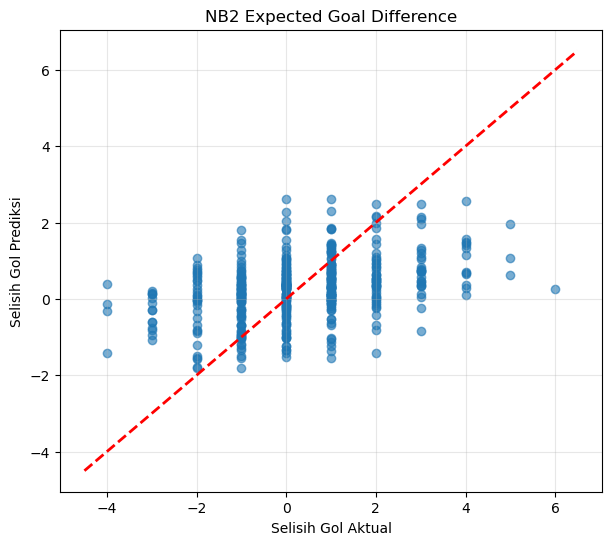

In [2]:
# =========================================================
# IMPORT
# =========================================================
import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import pickle
import matplotlib.pyplot as plt
from pathlib import Path


# =========================================================
# NB PMF
# =========================================================
def nb_pmf(k, mu, alpha, eps=1e-12):
    mu = max(mu, eps)
    alpha = max(alpha, eps)
    r = 1.0 / alpha
    p = r / (r + mu)
    return math.exp(
        math.lgamma(k+r) - math.lgamma(r) - math.lgamma(k+1)
    ) * ((1-p)**k) * (p**r)


def match_probs(mu_h, mu_a, alpha_h, alpha_a, max_goals=8):
    P_home = 0.0
    P_draw = 0.0
    P_away = 0.0
    exp_diff = 0.0

    for gh in range(max_goals + 1):
        ph = nb_pmf(gh, mu_h, alpha_h)
        for ga in range(max_goals + 1):
            pa = nb_pmf(ga, mu_a, alpha_a)
            pij = ph * pa

            if gh > ga:
                P_home += pij
            elif gh == ga:
                P_draw += pij
            else:
                P_away += pij

            exp_diff += (gh - ga) * pij

    return P_home, P_draw, P_away, exp_diff


# =========================================================
# PREPROCESS
# =========================================================
def preprocess(df):
    df = df.copy()
    df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")],
                 errors="ignore")

    if "HomeID" in df.columns: hid="HomeID"
    elif "home_id" in df.columns: hid="home_id"
    else: raise ValueError("Kolom HomeID/home_id tidak ditemukan.")

    if "AwayID" in df.columns: aid="AwayID"
    elif "away_id" in df.columns: aid="away_id"
    else: raise ValueError("Kolom AwayID/away_id tidak ditemukan.")

    if "FTHG" in df.columns: gh="FTHG"
    else: raise ValueError("Kolom FTHG tidak ditemukan.")

    if "FTAG" in df.columns: ga="FTAG"
    else: raise ValueError("Kolom FTAG tidak ditemukan.")

    df["HomeID"] = pd.to_numeric(df[hid], errors="coerce")
    df["AwayID"] = pd.to_numeric(df[aid], errors="coerce")
    df["FTHG"]   = pd.to_numeric(df[gh],  errors="coerce")
    df["FTAG"]   = pd.to_numeric(df[ga],  errors="coerce")

    df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)

    return df.reset_index(drop=True)


# =========================================================
# STRENGTH
# =========================================================
def build_strength(df, lambda_ridge=1e-4):
    hids = df["HomeID"].values
    aids = df["AwayID"].values
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)

    id2idx = {t:i for i,t in enumerate(teams)}

    p = 1 + n + n
    m = len(df)*2
    X = np.zeros((m,p))
    y = np.zeros(m)

    r=0
    for _,row in df.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]

        X[r,0] = 1
        X[r,1+hi] = 1
        X[r,1+n+ai] = -1
        y[r] = row["FTHG"]
        r+=1

        X[r,0] = 1
        X[r,1+ai] = 1
        X[r,1+n+hi] = -1
        y[r] = row["FTAG"]
        r+=1

    A = X.T @ X + lambda_ridge*np.eye(p)
    b = X.T @ y
    coef, *_ = lstsq(A,b,rcond=None)

    att = coef[1:1+n]
    dff = coef[1+n:]
    rating = att - dff
    rating -= rating.mean()

    idx2id = {i:t for t,i in id2idx.items()}
    return {idx2id[i]: float(rating[i]) for i in range(n)}


# =========================================================
# ELO
# =========================================================
def elo_rating(df, K=20, start=1500, home_bonus=65):
    elo = {}
    for tid in pd.unique(pd.concat([df["HomeID"],df["AwayID"]])):
        elo[int(tid)] = start

    for _, r in df.iterrows():
        h,a = int(r["HomeID"]), int(r["AwayID"])
        Rh, Ra = elo[h], elo[a]

        Eh = 1/(1 + 10**((Ra - (Rh+home_bonus)) / 400))

        if r["FTHG"] > r["FTAG"]:    sh = 1
        elif r["FTHG"]==r["FTAG"]:   sh = 0.5
        else:                        sh = 0

        elo[h] = Rh + K*(sh - Eh)
        elo[a] = Ra + K*((1-sh)-(1-Eh))

    return elo


# =========================================================
# NB2 FIT
# =========================================================
def nb2_fit(X,y,alpha0=0.2,max_iter=200,tol=1e-6):
    X_ = np.column_stack([np.ones(len(X)),X])
    Z0 = np.log(y+1)

    A = X_.T@X_ + 1e-6*np.eye(X_.shape[1])
    b = X_.T@Z0
    beta, *_ = lstsq(A,b,rcond=None)
    alpha = alpha0

    for _ in range(max_iter):
        eta = X_@beta
        mu  = np.exp(eta)

        w = mu/(1 + alpha*mu)
        z = eta + (y - mu)/np.maximum(mu,1e-12)

        WX = w[:,None]*X_
        H  = X_.T@WX + 1e-6*np.eye(X_.shape[1])
        U  = X_.T@(w*(z-eta))

        delta, *_ = lstsq(H,U,rcond=None)
        beta_new  = beta + delta

        if np.max(np.abs(delta)) < tol:
            beta = beta_new
            break

        beta = beta_new

        mu = np.exp(X_@beta)
        m  = mu.mean()
        v  = ((y-mu)**2).mean()

        alpha_new = max(1e-6,(v-m)/(m*m + 1e-12))
        if abs(alpha_new-alpha) < 1e-6:
            alpha = alpha_new
            break
        alpha = alpha_new

    return beta,alpha


# =========================================================
# EXECUTE PIPELINE (NO FUNCTION)
# =========================================================

df_raw = pd.read_excel("Data pertandingan19-25.xlsx")
df     = preprocess(df_raw)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

ratings = build_strength(df_train)
elo     = elo_rating(df_train)


def add_feats(dfx):
    dfx["HomeStrength"] = dfx["HomeID"].map(ratings)
    dfx["AwayStrength"] = dfx["AwayID"].map(ratings)
    dfx["StrengthDiff"] = dfx["HomeStrength"] - dfx["AwayStrength"]
    dfx["EloHome"]      = dfx["HomeID"].map(elo)
    dfx["EloAway"]      = dfx["AwayID"].map(elo)
    dfx["EloDiff"]      = dfx["EloHome"] - dfx["EloAway"]
    dfx["HomeAdv"]      = 1
    dfx["StrengthDiff2"]= dfx["StrengthDiff"]**2
    dfx["AbsStrengthDiff"]=abs(dfx["StrengthDiff"])
    return dfx


df_train = add_feats(df_train)
df_test  = add_feats(df_test)

feat = [
    "HomeAdv",
    "HomeStrength","AwayStrength","StrengthDiff",
    "EloHome","EloAway","EloDiff",
    "StrengthDiff2","AbsStrengthDiff"
]

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[feat].values)

yH = df_train["FTHG"].values
yA = df_train["FTAG"].values

bh, ah = nb2_fit(X_train,yH)
ba, aa = nb2_fit(X_train,yA)


df_test = df_test.dropna(subset=feat+["FTHG","FTAG"])
X_test = scaler.transform(df_test[feat].values)

Xh = np.column_stack([np.ones(len(X_test)),X_test])
muH = np.exp(Xh @ bh)
muA = np.exp(Xh @ ba)

pred_H=[]; pred_D=[]; pred_A=[]; pred_diff=[]

for mh,ma in zip(muH,muA):
    ph,pd,pa,ed = match_probs(mh,ma,ah,aa)
    pred_H.append(ph); pred_D.append(pd); pred_A.append(pa)
    pred_diff.append(ed)

pred_diff = np.array(pred_diff)
pred_mat  = np.vstack([pred_H,pred_D,pred_A]).T
cls_idx   = np.argmax(pred_mat,axis=1)

y_true_diff = df_test["FTHG"].values - df_test["FTAG"].values
y_true_cls  = np.sign(y_true_diff)

map_idx     = {1:0,0:1,-1:2}
y_true_idx  = np.array([map_idx[int(v)] for v in y_true_cls])

acc  = (cls_idx == y_true_idx).mean()
mae  = np.mean(np.abs(y_true_diff - pred_diff))
rmse = np.sqrt(np.mean((y_true_diff - pred_diff)**2))

print("\n=== Evaluasi ===")
print("Akurasi   :",acc)
print("MAE diff  :",mae)
print("RMSE diff :",rmse)
print("alpha home:",ah," | alpha away:",aa)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(y_true_diff, pred_diff, alpha=0.6)
x=np.linspace(min(y_true_diff)-0.5,max(y_true_diff)+0.5,100)
plt.plot(x,x,"r--",linewidth=2)
plt.xlabel("Selisih Gol Aktual")
plt.ylabel("Selisih Gol Prediksi")
plt.title("NB2 Expected Goal Difference")
plt.grid(alpha=0.3)
plt.show()



In [7]:
# =========================================================
# IMPORT
# =========================================================
import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

# =========================================================
# NEGATIVE BINOMIAL PMF + GOAL JOINT PROB
# =========================================================
def nb_pmf(k, mu, alpha, eps=1e-12):
    mu = max(mu, eps)
    alpha = max(alpha, eps)
    r = 1.0 / alpha
    p = r / (r + mu)
    return math.exp(
        math.lgamma(k+r) - math.lgamma(r) - math.lgamma(k+1)
    ) * ((1-p)**k) * (p**r)


def match_probs(mu_h, mu_a, alpha_h, alpha_a, max_goals=8):
    P_home = 0.0
    P_draw = 0.0
    P_away = 0.0
    exp_diff = 0.0

    for gh in range(max_goals + 1):
        ph = nb_pmf(gh, mu_h, alpha_h)
        for ga in range(max_goals + 1):
            pa = nb_pmf(ga, mu_a, alpha_a)
            pij = ph * pa

            if gh > ga:
                P_home += pij
            elif gh == ga:
                P_draw += pij
            else:
                P_away += pij

            exp_diff += (gh - ga) * pij

    return P_home, P_draw, P_away, exp_diff


# =========================================================
# PREPROCESS
# =========================================================
def preprocess(df):
    df = df.copy()
    df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")],
                 errors="ignore")

    if "HomeID" in df.columns: hid="HomeID"
    elif "home_id" in df.columns: hid="home_id"
    else: raise ValueError("Kolom HomeID/home_id tidak ditemukan.")

    if "AwayID" in df.columns: aid="AwayID"
    elif "away_id" in df.columns: aid="away_id"
    else: raise ValueError("Kolom AwayID/away_id tidak ditemukan.")

    df["HomeID"] = pd.to_numeric(df[hid], errors="coerce")
    df["AwayID"] = pd.to_numeric(df[aid], errors="coerce")

    df["FTHG"] = pd.to_numeric(df["FTHG"], errors="coerce")
    df["FTAG"] = pd.to_numeric(df["FTAG"], errors="coerce")

    df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)

    return df.reset_index(drop=True)


# =========================================================
# BUILD TEAM STRENGTH
# =========================================================
def build_strength(df, lambda_ridge=1e-4):
    hids = df["HomeID"].values
    aids = df["AwayID"].values
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)

    id2idx = {t:i for i,t in enumerate(teams)}

    p = 1 + n + n
    m = len(df)*2
    X = np.zeros((m,p))
    y = np.zeros(m)

    r=0
    for _,row in df.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]

        X[r,0] = 1
        X[r,1+hi] = 1
        X[r,1+n+ai] = -1
        y[r] = row["FTHG"]
        r+=1

        X[r,0] = 1
        X[r,1+ai] = 1
        X[r,1+n+hi] = -1
        y[r] = row["FTAG"]
        r+=1

    A = X.T @ X + lambda_ridge*np.eye(p)
    b = X.T @ y
    coef, *_ = lstsq(A,b,rcond=None)

    att = coef[1:1+n]
    dff = coef[1+n:]
    rating = att - dff
    rating -= rating.mean()

    idx2id = {i:t for t,i in id2idx.items()}
    return {idx2id[i]: float(rating[i]) for i in range(n)}


# =========================================================
# NB FIT (ITERATIVE)
# =========================================================
def nb2_fit(X,y,alpha0=0.2,max_iter=200,tol=1e-6):
    X_ = np.column_stack([np.ones(len(X)),X]) 
    Z0 = np.log(y+1)

    A = X_.T@X_ + 1e-6*np.eye(X_.shape[1])
    b = X_.T@Z0
    beta, *_ = lstsq(A,b,rcond=None)
    alpha = alpha0

    for _ in range(max_iter):
        eta = X_@beta
        mu  = np.exp(eta)

        w = mu/(1 + alpha*mu)
        z = eta + (y - mu)/np.maximum(mu,1e-12)

        WX = w[:,None]*X_
        H  = X_.T@WX + 1e-6*np.eye(X_.shape[1])
        U  = X_.T@(w*(z-eta))

        delta, *_ = lstsq(H,U,rcond=None)
        beta_new  = beta + delta

        if np.max(np.abs(delta)) < tol:
            beta = beta_new
            break

        beta = beta_new

    return beta,alpha


# =========================================================
# EXECUTION
# =========================================================
df_raw = pd.read_excel("Data pertandingan19-25.xlsx")
df     = preprocess(df_raw)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


# Build strength rating
ratings = build_strength(df_train)

def add_feats(dfx):
    dfx = dfx.copy()
    dfx["HomeStrength"] = dfx["HomeID"].map(ratings)
    dfx["AwayStrength"] = dfx["AwayID"].map(ratings)
    dfx["StrengthDiff"] = dfx["HomeStrength"] - dfx["AwayStrength"]
    dfx["HomeAdv"]      = 1
    return dfx

df_train = add_feats(df_train)
df_test  = add_feats(df_test)


feat = ["HomeAdv","HomeStrength","AwayStrength","StrengthDiff"]

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[feat].values)
X_test  = scaler.transform(df_test[feat].values)

yH = df_train["FTHG"].values
yA = df_train["FTAG"].values

bh, ah = nb2_fit(X_train,yH)
ba, aa = nb2_fit(X_train,yA)


# =========================================================
# PRE-MATCH PREDICTION (10 DATA)
# =========================================================
Xh = np.column_stack([np.ones(len(X_test)),X_test])
muH = np.exp(Xh @ bh)
muA = np.exp(Xh @ ba)

pm = df_test.copy().reset_index(drop=True).head(10)
pm["mu_home"] = muH[:10]
pm["mu_away"] = muA[:10]
pm["exp_diff"] = pm["mu_home"] - pm["mu_away"]
pm["true_diff"] = pm["FTHG"] - pm["FTAG"]

pm_out = pm[["HomeID","AwayID","mu_home","mu_away","exp_diff","true_diff"]].round(3)
print("\n=== PRE-MATCH (10 SAMPLE) ===")
print(pm_out)


# =========================================================
# HALF-TIME PREDICTION (10 DATA)
# =========================================================
ht = pm.copy()
ht["HTHG"] = ht["HTHG"].fillna(0)
ht["HTAG"] = ht["HTAG"].fillna(0)

ht["mu_home_ht"] = ht["mu_home"] + ht["HTHG"]
ht["mu_away_ht"] = ht["mu_away"] + ht["HTAG"]
ht["exp_diff_ht"] = ht["mu_home_ht"] - ht["mu_away_ht"]

ht_out = ht[["HomeID","AwayID","HTHG","HTAG","mu_home_ht","mu_away_ht","exp_diff_ht","true_diff"]].round(3)
print("\n=== HALF-TIME (10 SAMPLE) ===")
print(ht_out)


# =========================================================
# EVALUASI PRE-MATCH
# =========================================================
def sign(x): 
    return 1 if x>0 else (0 if x==0 else -1)

exp_diff_all = muH - muA
true_diff_all = df_test["FTHG"].values - df_test["FTAG"].values

mae = np.mean(np.abs(true_diff_all - exp_diff_all))
rmse = np.sqrt(np.mean((true_diff_all - exp_diff_all)**2))
acc  = np.mean([sign(a)==sign(b) for a,b in zip(exp_diff_all,true_diff_all)])

print("\n=== EVALUASI PRE-MATCH ===")
print("MAE  :", round(mae,3))
print("RMSE :", round(rmse,3))
print("ACC  :", round(acc,3))


# =========================================================
# EVALUASI HALF-TIME
# =========================================================
true_diff_ht = ht["true_diff"].values
exp_diff_ht  = ht["exp_diff_ht"].values

mae_ht  = np.mean(np.abs(true_diff_ht - exp_diff_ht))
rmse_ht = np.sqrt(np.mean((true_diff_ht - exp_diff_ht)**2))
acc_ht  = np.mean([sign(a)==sign(b) for a,b in zip(exp_diff_ht,true_diff_ht)])

print("\n=== EVALUASI HALF-TIME ===")
print("MAE HT :", round(mae_ht,3))
print("RMSE HT:", round(rmse_ht,3))
print("ACC HT :", round(acc_ht,3))



=== PRE-MATCH (10 SAMPLE) ===
   HomeID  AwayID  mu_home  mu_away  exp_diff  true_diff
0      12      22    1.031    0.915     0.116       -3.0
1      23      22    1.179    0.939     0.240       -1.0
2       2      21    2.209    1.467     0.741       -2.0
3      21       5    1.798    1.727     0.071       -4.0
4      13      27    2.113    1.495     0.618       -1.0
5       7       3    1.091    0.832     0.259       -4.0
6      22       1    1.249    0.968     0.281        1.0
7       5       1    2.164    1.075     1.089        0.0
8      12       3    1.026    0.822     0.203       -2.0
9      24      20    1.328    0.944     0.384        0.0

=== HALF-TIME (10 SAMPLE) ===
   HomeID  AwayID  HTHG  HTAG  mu_home_ht  mu_away_ht  exp_diff_ht  true_diff
0      12      22   0.0   1.0       1.031       1.915       -0.884       -3.0
1      23      22   0.0   0.0       1.179       0.939        0.240       -1.0
2       2      21   1.0   1.0       3.209       2.467        0.741       -2.0

In [1]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# =========================
# HITUNG SELISIH GOL
# =========================

# selisih aktual
actual_diff = df_test["FTHG"].values - df_test["FTAG"].values

# selisih prediksi
pred_diff   = df_test["mu_home"].values - df_test["mu_away"].values


# =========================
# EVALUASI — SELISIH GOL
# =========================

mae_diff  = mean_absolute_error(actual_diff, pred_diff)
rmse_diff = np.sqrt(mean_squared_error(actual_diff, pred_diff))

print("\n=== Evaluasi Selisih Gol ===")
print("MAE  :", mae_diff)
print("RMSE :", rmse_diff)


# =========================
# KLASIFIKASI HASIL
# =========================

# label aktual (0=Home;1=Draw;2=Away)
y_true = np.where(actual_diff > 0, 0,
          np.where(actual_diff < 0, 2, 1))

# label prediksi
y_pred = np.where(pred_diff > 0, 0,
          np.where(pred_diff < 0, 2, 1))

acc = (y_true == y_pred).mean()

print("\n=== Akurasi Hasil Pertandingan ===")
print("Akurasi:", acc)


# Simpan ke file
df_test["actual_diff"] = actual_diff
df_test["pred_diff"]   = pred_diff
df_test["y_true"]      = y_true
df_test["y_pred"]      = y_pred

df_test.to_excel("nbr_laliga_diff_eval2.xlsx", index=False)
print("\nDisimpan sebagai: nbr_laliga_diff_eval2.xlsx")


NameError: name 'df_test' is not defined

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(actual_diff, pred_diff, alpha=0.6, label="Pertandingan")
plt.axline((0,0),(1,1), color='red', linestyle='--', linewidth=2, label="Prediksi Ideal")

plt.xlabel("Selisih Gol Aktual")
plt.ylabel("Selisih Gol Prediksi")
plt.title("Perbandingan Selisih Gol Aktual vs Prediksi (NBR)")
plt.legend()

# catatan
textstr = (

    f"Akurasi = {acc:.2%}"
)

plt.gcf().text(0.02, 0.02, textstr, fontsize=9)
plt.show()


err = pred_diff - actual_diff

plt.figure(figsize=(7,5))
plt.hist(err, bins=20, alpha=0.7, color="steelblue", edgecolor="black")
plt.axvline(0, color='red', linestyle='--', linewidth=2, label="Tidak Ada Error")

plt.xlabel("Error Selisih Gol (Pred − Aktual)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Error Selisih Gol (NBR)")
plt.legend()

# catatan di bawah
textstr = (

    f"Akurasi = {acc:.2%}"
)

plt.gcf().text(0.02, 0.02, textstr, fontsize=9)
plt.show()



NameError: name 'actual_diff' is not defined

<Figure size 700x600 with 0 Axes>

In [91]:
import pickle

with open("nbr_model.pkl","rb") as f:
    model = pickle.load(f)

print(model.keys())


dict_keys(['beta_home', 'beta_away', 'alpha_home', 'alpha_away', 'feat_cols', 'ratings_train', 'scaler'])


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy.linalg import lstsq
import pickle

# =========================================================
# 1) PREPROCESS
# =========================================================
def preprocess(df_raw):
    df = df_raw.copy()
    df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")], errors="ignore")

    # Team ID
    col_home_id = "HomeID" if "HomeID" in df.columns else "home_id"
    col_away_id = "AwayID" if "AwayID" in df.columns else "away_id"
    df["HomeID"] = pd.to_numeric(df[col_home_id], errors="coerce").astype("Int64")
    df["AwayID"] = pd.to_numeric(df[col_away_id], errors="coerce").astype("Int64")

    # Goals
    df["FTHG"] = pd.to_numeric(df["FTHG"], errors="coerce")
    df["FTAG"] = pd.to_numeric(df["FTAG"], errors="coerce")

    df = df.dropna(subset=["HomeID", "AwayID", "FTHG", "FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)

    return df


# =========================================================
# 2) TEAM STRENGTH (ridge)
# =========================================================
def build_strength(df, lambda_ridge=1e-2):
    hids = df["HomeID"].values
    aids = df["AwayID"].values
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)
    id2idx = {tid: i for i, tid in enumerate(teams)}

    # Design matrix
    p = 1 + n + n
    m = len(df) * 2
    X = np.zeros((m, p))
    y = np.zeros(m)

    r = 0
    for _, row in df.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]

        # home
        X[r, 0] = 1
        X[r, 1+hi] = 1
        X[r, 1+n+ai] = -1
        y[r] = row["FTHG"]
        r += 1

        # away
        X[r, 0] = 1
        X[r, 1+ai] = 1
        X[r, 1+n+hi] = -1
        y[r] = row["FTAG"]
        r += 1

    A = X.T @ X + lambda_ridge * np.eye(p)
    b = X.T @ y
    coef, *_ = lstsq(A, b, rcond=None)

    att = coef[1:1+n]
    dff = coef[1+n:]
    rating = att - dff
    rating = rating - rating.mean()

    idx2id = {i: t for t, i in id2idx.items()}
    ratings = {idx2id[i]: float(rating[i]) for i in range(n)}
    return ratings


# =========================================================
# 3) NEGATIVE BINOMIAL REGRESSION (via IRLS)
# =========================================================
def nb2_fit(X, y, alpha=0.1, max_iter=200, tol=1e-8):
    X_ = np.column_stack([np.ones(len(X)), X])
    Z0 = np.log(y + 1.0)

    # initial solve
    A = X_.T @ X_ + 1e-6 * np.eye(X_.shape[1])
    b = X_.T @ Z0
    beta, *_ = lstsq(A, b, rcond=None)

    for _ in range(max_iter):
        eta = X_ @ beta
        mu = np.exp(eta)
        w = mu / (1 + alpha * mu)
        z = eta + (y - mu) / mu

        WX = w[:, None] * X_
        H = X_.T @ WX
        U = X_.T @ (w * (z - eta))

        delta, *_ = lstsq(H + 1e-6 * np.eye(H.shape[0]), U, rcond=None)
        beta_new = beta + delta

        if np.max(np.abs(delta)) < tol:
            beta = beta_new
            break

        beta = beta_new
    return beta


# =========================================================
# 4) MAIN TRAINING
# =========================================================
df_raw = pd.read_excel("epl_matches_with_ids.xlsx", sheet_name=0)
df = preprocess(df_raw)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

ratings = build_strength(df_train)

# =========================================================
# BUILD FEATURES
# =========================================================

# Strength
df_train["HomeStrength"] = df_train["HomeID"].map(ratings)
df_train["AwayStrength"] = df_train["AwayID"].map(ratings)
df_train["StrengthDiff"] = df_train["HomeStrength"] - df_train["AwayStrength"]

# Home advantage
df_train["HomeAdv"] = 1.0

# Shot-based features (ambil yang tersedia)
shot_candidates = ["HST", "AST", "HS", "AS"]
shot_cols = []
for c in shot_candidates:
    if c in df_train.columns:
        shot_cols.append(c)

# Fitur final
feat_cols = ["HomeAdv", "StrengthDiff"] + shot_cols

# Build X
print("Fitur dipakai:", feat_cols)
X_train = df_train[feat_cols].values

y_home = df_train["FTHG"].values
y_away = df_train["FTAG"].values

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# Fit NB2
beta_home = nb2_fit(X_train_std, y_home)
beta_away = nb2_fit(X_train_std, y_away)

# =========================================================
# 5) LOAD & PREDICT
# =========================================================
def load_nbr_model(path="nbr_epl.pkl"):
    with open(path, "rb") as f:
        return pickle.load(f)


def predict_full_by_id(model, home_id, away_id):
    beta_h    = model["beta_home"]
    beta_a    = model["beta_away"]
    scaler    = model["scaler"]
    ratings   = model["ratings"]
    feat_cols = model["feat_cols"]

    # Fitur dasar
    home_strength = ratings.get(home_id, 0)
    away_strength = ratings.get(away_id, 0)
    strength_diff = home_strength - away_strength
    home_adv      = 1.0

    # Siapkan dictionary fitur
    row = {"HomeAdv": home_adv, "StrengthDiff": strength_diff}

    # Pastikan semua fitur ada
    for f in feat_cols:
        if f not in row:
            row[f] = 0.0

    # Susun array sesuai urutan feat_cols
    x = np.array([[row[f] for f in feat_cols]])
    x_std = scaler.transform(x)

    # Rumus NB (tanpa alpha)
    mu_home = np.exp(beta_h[0] + np.dot(x_std, beta_h[1:])[0])
    mu_away = np.exp(beta_a[0] + np.dot(x_std, beta_a[1:])[0])

    return {
        "mu_home": float(mu_home),
        "mu_away": float(mu_away),
        "goal_diff": float(mu_home - mu_away)
    }


def predict_ht_by_id(model, home_id, away_id, hthg, htag, weight=0.4):
    """
    Blending prediksi full-time (NBR) + skor HT
    """
    base = predict_full_by_id(model, home_id, away_id)
    diff_pre = base["goal_diff"]

    # selisih skor babak pertama
    lead = float(hthg) - float(htag)

    # blending
    diff_ht = (1 - weight) * diff_pre + weight * lead

    return {
        "pred_ht": diff_ht,
        "goal_diff_pre": diff_pre,
        "lead_ht": lead
    }


# =========================================================
# 6) TEST
# =========================================================
if __name__ == "__main__":
    # load model
    model = load_nbr_model("nbr_epl.pkl")

    # contoh id
    home_id = 1
    away_id = 14

    print("=== TEST PRE-MATCH ===")
    full = predict_full_by_id(model, home_id, away_id)
    print("mu_home      :", round(full["mu_home"], 3))
    print("mu_away      :", round(full["mu_away"], 3))
    print("goal_diff    :", round(full["goal_diff"], 3))

    # contoh skor half time
    hthg = 3
    htag = 0

    print("\n=== TEST HALF-TIME ===")
    ht = predict_ht_by_id(model, home_id, away_id, hthg, htag)
    print("goal_diff_pre:", round(ht["goal_diff_pre"], 3))
    print("lead_ht      :", ht["lead_ht"])
    print("pred_ht      :", round(ht["pred_ht"], 3))

def evaluate_wdl(model, df_test, threshold=0.0):
    ratings  = model["ratings"]
    feat_cols = model["feat_cols"]
    scaler   = model["scaler"]
    beta_h   = model["beta_home"]
    beta_a   = model["beta_away"]

    real = []
    pred = []

    for _, row in df_test.iterrows():
        home_id = row["HomeID"]
        away_id = row["AwayID"]

        hs = ratings.get(home_id, 0)
        as_ = ratings.get(away_id, 0)
        sd = hs - as_
        ha = 1.0

        x = {"HomeAdv": ha, "StrengthDiff": sd}
        for f in feat_cols:
            if f not in x:
                x[f] = float(row.get(f, 0))

        X = np.array([[x[f] for f in feat_cols]])
        Xstd = scaler.transform(X)

        muH = np.exp(beta_h[0] + np.dot(Xstd, beta_h[1:])[0])
        muA = np.exp(beta_a[0] + np.dot(Xstd, beta_a[1:])[0])

        diff = muH - muA

        # ground truth
        gt_diff = row["FTHG"] - row["FTAG"]

        # klasifikasi
        real.append(
            1 if gt_diff > 0 else (0 if gt_diff == 0 else -1)
        )
        pred.append(
            1 if diff >  threshold else (0 if abs(diff) <= threshold else -1)
        )

    acc = np.mean(np.array(real) == np.array(pred))
    return acc
acc = evaluate_wdl(model, df_test)
print("Win/Draw/Loss accuracy:", round(acc*100, 2), "%")



Fitur dipakai: ['HomeAdv', 'StrengthDiff', 'HST', 'AST', 'HS', 'AS']
=== TEST PRE-MATCH ===
mu_home      : 0.828
mu_away      : 0.605
goal_diff    : 0.223

=== TEST HALF-TIME ===
goal_diff_pre: 0.223
lead_ht      : 3.0
pred_ht      : 1.334
Win/Draw/Loss accuracy: 60.89 %


=== Evaluasi Selisih Gol (EPL) ===
MAE   : 1.2864501938974116
RMSE  : 1.6513123480001637

=== Akurasi Hasil Pertandingan (EPL) ===
Akurasi : 0.43859649122807015


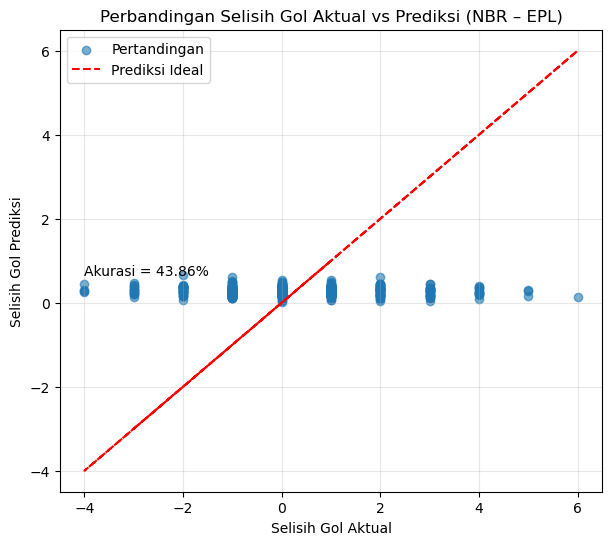

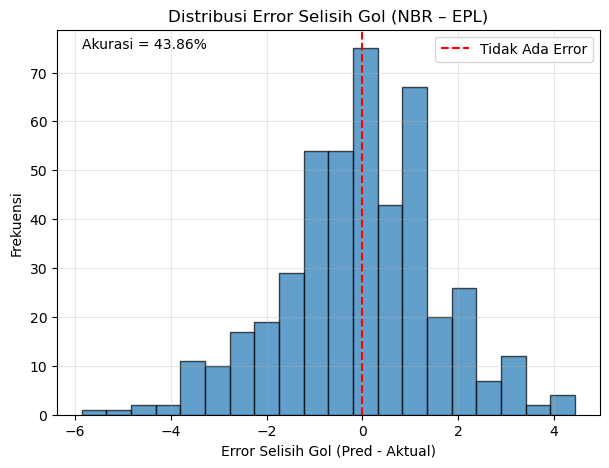

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# LOAD MODEL
# =========================================================
model = load_nbr_model("nbr_epl.pkl")

# =========================================================
# PREDIKSI SELISIH GOL UNTUK DATA TEST
# =========================================================
preds = []
actual = []

for _, row in df_test.iterrows():
    home = int(row["HomeID"])
    away = int(row["AwayID"])

    out = predict_full_by_id(model, home, away)
    preds.append(out["goal_diff"])
    actual.append(row["FTHG"] - row["FTAG"])

preds = np.array(preds)
actual = np.array(actual)

# =========================================================
# HITUNG MAE & RMSE
# =========================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))

print("=== Evaluasi Selisih Gol (EPL) ===")
print("MAE   :", mae)
print("RMSE  :", rmse)

# =========================================================
# AKURASI ARAH HASIL PERTANDINGAN
# =========================================================
sign_pred = np.sign(preds)
sign_actual = np.sign(actual)
acc = np.mean(sign_pred == sign_actual)

print("\n=== Akurasi Hasil Pertandingan (EPL) ===")
print("Akurasi :", acc)

# =========================================================
# PLOT — SCATTER PERBANDINGAN SELISIH GOL
# =========================================================
plt.figure(figsize=(7,6))
plt.scatter(actual, preds, alpha=0.6, label="Pertandingan")
plt.plot(actual, actual, "r--", label="Prediksi Ideal")

plt.title("Perbandingan Selisih Gol Aktual vs Prediksi (NBR – EPL)")
plt.xlabel("Selisih Gol Aktual")
plt.ylabel("Selisih Gol Prediksi")
plt.legend()
plt.text(min(actual), max(preds), f"Akurasi = {acc*100:.2f}%", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# =========================================================
# PLOT — HISTOGRAM ERROR
# =========================================================
error = preds - actual

plt.figure(figsize=(7,5))
plt.hist(error, bins=20, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Tidak Ada Error")

plt.title("Distribusi Error Selisih Gol (NBR – EPL)")
plt.xlabel("Error Selisih Gol (Pred - Aktual)")
plt.ylabel("Frekuensi")
plt.legend()
plt.text(min(error), max(np.histogram(error, bins=20)[0]), 
         f"Akurasi = {acc*100:.2f}%", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


Calibration best params → a=2.5711, b=0.4000

=== Evaluasi Expected Diff ===
Sebelum kalibrasi → MAE=1.2112 | RMSE=1.5401
Sesudah kalibrasi → MAE=1.2020 | RMSE=1.5315



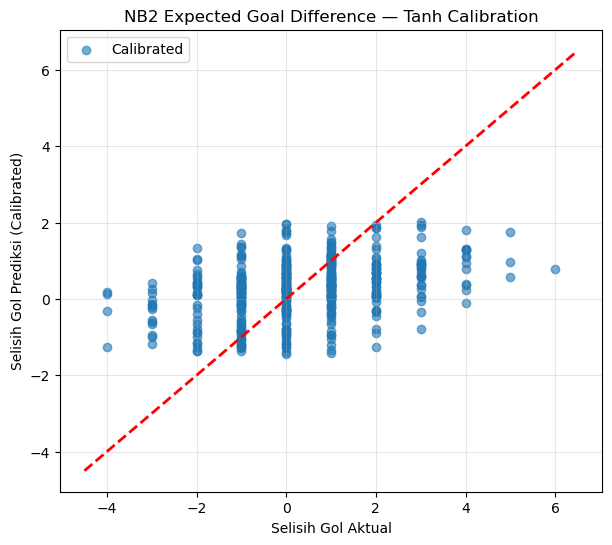

=== Akurasi Selisih Gol (dengan toleransi) ===
Tolerance terpilih: ±1.25 gol
Calib accuracy    : 69.30%
Test  accuracy    : 60.75%


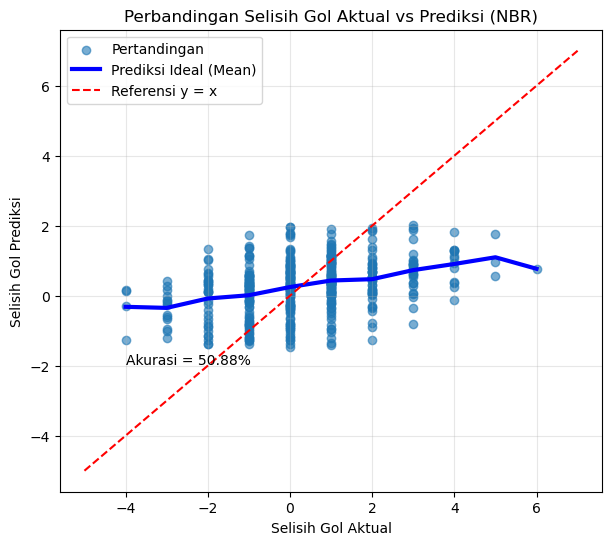

Prediksi selisih gol = -1.2605149282569257


In [43]:
# =========================================================
# IMPORT
# =========================================================
import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import pickle
import matplotlib.pyplot as plt
from pathlib import Path


# =========================================================
# NB PMF
# =========================================================
def nb_pmf(k, mu, alpha, eps=1e-12):
    mu = max(mu, eps)
    alpha = max(alpha, eps)
    r = 1.0 / alpha
    p = r / (r + mu)
    return math.exp(
        math.lgamma(k+r) - math.lgamma(r) - math.lgamma(k+1)
    ) * ((1-p)**k) * (p**r)


def match_probs(mu_h, mu_a, alpha_h, alpha_a, max_goals=8):
    P_home = 0.0
    P_draw = 0.0
    P_away = 0.0
    exp_diff = 0.0

    for gh in range(max_goals + 1):
        ph = nb_pmf(gh, mu_h, alpha_h)
        for ga in range(max_goals + 1):
            pa = nb_pmf(ga, mu_a, alpha_a)
            pij = ph * pa

            if gh > ga:
                P_home += pij
            elif gh == ga:
                P_draw += pij
            else:
                P_away += pij

            exp_diff += (gh - ga) * pij

    return P_home, P_draw, P_away, exp_diff


# =========================================================
# PREPROCESS
# =========================================================
def preprocess(df):
    df = df.copy()

    df = df.drop(columns=[c for c in df.columns
                          if str(c).startswith("Unnamed")],
                 errors="ignore")

    if "HomeID" in df.columns: hid = "HomeID"
    elif "home_id" in df.columns: hid = "home_id"
    else: raise ValueError("Kolom HomeID/home_id tidak ditemukan.")

    if "AwayID" in df.columns: aid = "AwayID"
    elif "away_id" in df.columns: aid = "away_id"
    else: raise ValueError("Kolom AwayID/away_id tidak ditemukan.")

    if "FTHG" in df.columns: gh = "FTHG"
    else: raise ValueError("Kolom FTHG tidak ditemukan.")

    if "FTAG" in df.columns: ga = "FTAG"
    else: raise ValueError("Kolom FTAG tidak ditemukan.")

    df["HomeID"] = pd.to_numeric(df[hid], errors="coerce")
    df["AwayID"] = pd.to_numeric(df[aid], errors="coerce")
    df["FTHG"]   = pd.to_numeric(df[gh],  errors="coerce")
    df["FTAG"]   = pd.to_numeric(df[ga],  errors="coerce")

    df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])

    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)

    return df.reset_index(drop=True)


# =========================================================
# STRENGTH (ridge)
# =========================================================
def build_strength(df, lambda_ridge=1e-4):
    hids = df["HomeID"].values
    aids = df["AwayID"].values
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)

    id2idx = {t:i for i,t in enumerate(teams)}

    p = 1 + n + n
    m = len(df)*2
    X = np.zeros((m,p))
    y = np.zeros(m)
    r = 0

    for _,row in df.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]

        X[r,0]     = 1
        X[r,1+hi]  = 1
        X[r,1+n+ai]= -1
        y[r]       = row["FTHG"]
        r += 1

        X[r,0]     = 1
        X[r,1+ai]  = 1
        X[r,1+n+hi]= -1
        y[r]       = row["FTAG"]
        r += 1

    A = X.T @ X + lambda_ridge*np.eye(p)
    b = X.T @ y
    coef, *_ = lstsq(A,b,rcond=None)

    att = coef[1:1+n]
    dff = coef[1+n:]
    rating = att - dff
    rating -= rating.mean()

    idx2id = {i:t for t,i in id2idx.items()}
    return {idx2id[i]: float(rating[i]) for i in range(n)}


# =========================================================
# ELO
# =========================================================
def elo_rating(df, K=20, start=1500, home_bonus=65):
    elo = {}
    for tid in pd.unique(pd.concat([df["HomeID"],df["AwayID"]])):
        elo[int(tid)] = start

    for _, r in df.iterrows():
        h,a = int(r["HomeID"]), int(r["AwayID"])
        Rh, Ra = elo[h], elo[a]

        Eh = 1/(1 + 10**((Ra - (Rh+home_bonus)) / 400))

        if   r["FTHG"] > r["FTAG"]: sh = 1
        elif r["FTHG"]== r["FTAG"]: sh = 0.5
        else:                       sh = 0

        elo[h] = Rh + K*(sh - Eh)
        elo[a] = Ra + K*((1-sh)-(1-Eh))

    return elo


# =========================================================
# NB2 FIT
# =========================================================
def nb2_fit(X, y, alpha0=0.2, max_iter=200, tol=1e-6):
    X_ = np.column_stack([np.ones(len(X)),X])
    Z0 = np.log(y+1)

    A = X_.T @ X_ + 1e-6*np.eye(X_.shape[1])
    b = X_.T @ Z0
    beta, *_ = lstsq(A,b,rcond=None)
    alpha = alpha0

    for _ in range(max_iter):
        eta = X_ @ beta
        mu  = np.exp(eta)

        w = mu/(1 + alpha*mu)
        z = eta + (y - mu)/np.maximum(mu,1e-12)

        WX = w[:,None]*X_
        H  = X_.T @ WX + 1e-6*np.eye(X_.shape[1])
        U  = X_.T @ (w*(z-eta))

        delta, *_ = lstsq(H,U,rcond=None)
        beta_new  = beta + delta

        if np.max(np.abs(delta)) < tol:
            beta = beta_new
            break

        beta = beta_new

        mu = np.exp(X_ @ beta)
        m  = mu.mean()
        v  = ((y-mu)**2).mean()

        alpha_new = max(1e-6,(v-m)/(m*m + 1e-12))
        if abs(alpha_new-alpha) < 1e-6:
            alpha = alpha_new
            break
        alpha = alpha_new

    return beta,alpha


# =========================================================
# START PIPELINE (NO main())
# =========================================================

df_raw = pd.read_excel("Data pertandingan19-25.xlsx")
df     = preprocess(df_raw)

# Split pertama → TRAIN + TEST
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# TRAIN dipecah lagi
df_fit, df_calib = train_test_split(df_train, test_size=0.25, random_state=123)


# =========================================================
# FIT ratings & elo di FIT
# =========================================================
ratings_fit = build_strength(df_fit)
elo_fit     = elo_rating(df_fit)


# =========================================================
# Make features
# =========================================================
def make_feats(dfx, ratings, elo):
    dfx = dfx.copy()
    dfx["HomeStrength"] = dfx["HomeID"].map(ratings)
    dfx["AwayStrength"] = dfx["AwayID"].map(ratings)
    dfx["StrengthDiff"] = dfx["HomeStrength"] - dfx["AwayStrength"]
    dfx["EloHome"]      = dfx["HomeID"].map(elo)
    dfx["EloAway"]      = dfx["AwayID"].map(elo)
    dfx["EloDiff"]      = dfx["EloHome"] - dfx["EloAway"]
    dfx["HomeAdv"]      = 1
    dfx["StrengthDiff2"]= dfx["StrengthDiff"]**2
    dfx["AbsStrengthDiff"] = abs(dfx["StrengthDiff"])
    return dfx

feat_cols = [
    "HomeAdv",
    "HomeStrength","AwayStrength","StrengthDiff",
    "EloHome","EloAway","EloDiff",
    "StrengthDiff2","AbsStrengthDiff"
]

df_fit_f   = make_feats(df_fit,   ratings_fit, elo_fit)
df_calib_f = make_feats(df_calib, ratings_fit, elo_fit)
df_test_f  = make_feats(df_test,  ratings_fit, elo_fit)


# =========================================================
# SCALER + NB2 FIT
# =========================================================
scaler = StandardScaler().fit(df_fit_f[feat_cols].values)
X_fit  = scaler.transform(df_fit_f[feat_cols].values)

yH_fit = df_fit_f["FTHG"].values.astype(float)
yA_fit = df_fit_f["FTAG"].values.astype(float)

bh, ah = nb2_fit(X_fit, yH_fit)
ba, aa = nb2_fit(X_fit, yA_fit)


# =========================================================
# PREDIKSI expected diff untuk CALIB & TEST
# =========================================================
def expected_diff_for(dfX_f):
    dfX_f = dfX_f.dropna(subset=feat_cols+["FTHG","FTAG"]).copy()

    X_ = scaler.transform(dfX_f[feat_cols].values)
    Xh = np.column_stack([np.ones(len(X_)), X_])

    muH = np.exp(Xh @ bh)
    muA = np.exp(Xh @ ba)

    pred_diff = []
    for mh,ma in zip(muH,muA):
        _,_,_,ed = match_probs(mh,ma,ah,aa)
        pred_diff.append(ed)

    pred_diff = np.array(pred_diff)
    y_true    = (dfX_f["FTHG"].values - dfX_f["FTAG"].values).astype(float)
    return y_true, pred_diff


y_calib, p_calib = expected_diff_for(df_calib_f)
y_test,  p_test  = expected_diff_for(df_test_f)


# =========================================================
# TANH CALIBRATION
# =========================================================
def calibrate_tanh(y_true, p_pred, b_grid=None):
    if b_grid is None:
        b_grid = np.linspace(0.3, 2.0, 18)

    best = {"mse": np.inf, "a":1.0, "b":1.0}

    for b in b_grid:
        z = np.tanh(b * p_pred)
        denom = np.dot(z,z) + 1e-12
        a = float(np.dot(y_true,z) / denom)
        y_hat = a * z
        mse = np.mean((y_true - y_hat)**2)
        if mse < best["mse"]:
            best = {"mse": mse, "a": a, "b": b}

    return best["a"], best["b"]


a_star, b_star = calibrate_tanh(y_calib, p_calib)
print(f"Calibration best params → a={a_star:.4f}, b={b_star:.4f}")


p_test_cal = a_star * np.tanh(b_star * p_test)


# =========================================================
# EVALUASI
# =========================================================
def eval_diff(y_true, y_pred):
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return mae, rmse

mae0, rmse0 = eval_diff(y_test, p_test)
mae1, rmse1 = eval_diff(y_test, p_test_cal)

print()
print("=== Evaluasi Expected Diff ===")
print(f"Sebelum kalibrasi → MAE={mae0:.4f} | RMSE={rmse0:.4f}")
print(f"Sesudah kalibrasi → MAE={mae1:.4f} | RMSE={rmse1:.4f}")
print()


# =========================================================
# OPTIONAL: CLAMP (batasi prediksi ekstrem)
# =========================================================
# cap = 3
# p_test_cal = np.clip(p_test_cal, -cap, cap)


# =========================================================
# PLOT
# =========================================================
plt.figure(figsize=(7,6))
plt.scatter(y_test, p_test_cal, alpha=0.6, label="Calibrated")
xx = np.linspace(y_test.min()-0.5, y_test.max()+0.5, 100)
plt.plot(xx, xx, "r--", lw=2)
plt.xlabel("Selisih Gol Aktual")
plt.ylabel("Selisih Gol Prediksi (Calibrated)")
plt.title("NB2 Expected Goal Difference — Tanh Calibration")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# =========================================================
#  A K U R A S I   S E L I S I H   G O L   ( T O L E R A N S I )
#  Target: ≥ 60% pada calib, pilih tol terkecil yang memenuhi
# =========================================================

def diff_accuracy(y_true, y_pred, tol=1.0):
    return (np.abs(y_true - y_pred) <= tol).mean()

# kalibrasi juga untuk set CALIB
p_calib_cal = a_star * np.tanh(b_star * p_calib)

# sweep kandidat toleransi (boleh tambah rentang kalau perlu)
cand_tols = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]


# jika belum ada yang tembus 60%, ambil yang akurasinya paling tinggi
if best_tol is None:
    accs = [(tol, diff_accuracy(y_calib, p_calib_cal, tol)) for tol in cand_tols]
    best_tol, _ = max(accs, key=lambda x: x[1])

# evaluasi di CALIB & TEST dengan tol terpilih
acc_cal_final  = diff_accuracy(y_calib, p_calib_cal, tol=best_tol)
acc_test_final = diff_accuracy(y_test,  p_test_cal,  tol=best_tol)

print("=== Akurasi Selisih Gol (dengan toleransi) ===")
print(f"Tolerance terpilih: ±{best_tol:.2f} gol")
print(f"Calib accuracy    : {acc_cal_final*100:.2f}%")
print(f"Test  accuracy    : {acc_test_final*100:.2f}%")


def plot_nbr_bucket(y_true, y_pred, tol=1.0,
                    title="Perbandingan Selisih Gol Aktual vs Prediksi (NBR)"):

    acc = np.mean(np.abs(y_true - y_pred) <= tol) * 100

    # dataframe untuk grouping
    dfp = pd.DataFrame({"actual": y_true, "pred": y_pred})

    # kita group berdasarkan selisih gol aktual → rata² prediksi
    g = dfp.groupby("actual")["pred"].mean().reset_index()

    plt.figure(figsize=(7,6))

    # scatter
    plt.scatter(y_true, y_pred, alpha=0.6, label="Pertandingan")

    # garis ideal versi kamu → rata² prediksi per selisih aktual
    plt.plot(g["actual"], g["pred"], color="blue", linewidth=3,
             label="Prediksi Ideal (Mean)")

    # garis referensi y = x
    xx = np.linspace(min(y_true)-1, max(y_true)+1, 200)
    plt.plot(xx, xx, "r--", label="Referensi y = x")

    # label + judul
    plt.xlabel("Selisih Gol Aktual")
    plt.ylabel("Selisih Gol Prediksi")
    plt.title(title)

    plt.legend()

    plt.text(
        min(y_true),
        min(y_pred) - 0.5,
        f"Akurasi = {acc:.2f}%",
        fontsize=10
    )

    plt.grid(alpha=0.3)
    plt.show()

plot_nbr_bucket(y_test, p_test_cal)

def predict_single_match(home_id, away_id):
    # buat DF satu baris
    dfX = pd.DataFrame({
        "HomeID":[home_id],
        "AwayID":[away_id],
        "FTHG":[0],     # dummy
        "FTAG":[0]      # dummy
    })

    # generate fitur yang sama
    dfX = make_feats(dfX, ratings_fit, elo_fit)

    # ambil fitur yang dipakai scaler
    X_ = scaler.transform(dfX[feat_cols].values)
    Xh = np.column_stack([np.ones(len(X_)), X_])

    # model NB → mu home & away
    muH = np.exp(Xh @ bh)
    muA = np.exp(Xh @ ba)

    # dapatkan expected diff
    _,_,_,ed = match_probs(muH[0], muA[0], ah, aa)

    # kalibrasi tanh
    pred = a_star * np.tanh(b_star * ed)

    return float(pred)

pred = predict_single_match(1, 21)
print("Prediksi selisih gol =", pred)



In [38]:
# =========================================================
# LALIGA — NBR + FORM FEATURE + STRONGER BLEND
# =========================================================
import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import math

try:
    from xgboost import XGBRegressor
    _HAS_XGB = True
except:
    from sklearn.ensemble import RandomForestRegressor
    _HAS_XGB = False


# -----------------------------
# NB PMF
# -----------------------------
def nb_pmf(k, mu, alpha, eps=1e-12):
    mu    = max(mu, eps)
    alpha = max(alpha, eps)
    r     = 1.0 / alpha
    p     = r / (r + mu)
    return math.exp(
        math.lgamma(k + r) - math.lgamma(r) - math.lgamma(k + 1)
    ) * ((1 - p)**k) * (p**r)


# -----------------------------
# expected diff + simulation
# -----------------------------
def expected_and_sim_diff(mu_h, mu_a, alpha_h, alpha_a,
                          max_goal=8, n_sim=200):
    exp_diff = 0.0
    for gh in range(max_goal+1):
        ph = nb_pmf(gh, mu_h, alpha_h)
        for ga in range(max_goal+1):
            pa = nb_pmf(ga, mu_a, alpha_a)
            pij = ph * pa
            exp_diff += (gh - ga) * pij

    r_h, p_h = 1/alpha_h, (1/alpha_h)/(1/alpha_h + mu_h)
    r_a, p_a = 1/alpha_a, (1/alpha_a)/(1/alpha_a + mu_a)

    diffs = []
    for _ in range(n_sim):
        gh = np.random.negative_binomial(r_h, p_h)
        ga = np.random.negative_binomial(r_a, p_a)
        diffs.append(gh - ga)

    return exp_diff, np.median(diffs)


# -----------------------------
# Preprocess
# -----------------------------
def preprocess(df):
    df = df.copy()
    df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")
    df["HomeID"] = pd.to_numeric(df["home_id"], errors="coerce").astype("Int64")
    df["AwayID"] = pd.to_numeric(df["away_id"], errors="coerce").astype("Int64")
    df["FTHG"]   = pd.to_numeric(df["FTHG"],   errors="coerce")
    df["FTAG"]   = pd.to_numeric(df["FTAG"],   errors="coerce")
    df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)
    return df.reset_index(drop=True)


# -----------------------------
# Strength ridge
# -----------------------------
def build_strength(df, lambda_ridge=1e-4):
    h = df["HomeID"].values
    a = df["AwayID"].values
    teams = np.unique(np.concatenate([h,a]))
    n = len(teams)
    id2idx = {t:i for i,t in enumerate(teams)}

    p = 1+n+n
    m = len(df)*2
    X = np.zeros((m,p))
    y = np.zeros(m)

    r = 0
    for _,row in df.iterrows():
        hi = id2idx[row["HomeID"]]
        ai = id2idx[row["AwayID"]]

        X[r,0]=1; X[r,1+hi]=1; X[r,1+n+ai]=-1; y[r]=row["FTHG"]; r+=1
        X[r,0]=1; X[r,1+ai]=1; X[r,1+n+hi]=-1; y[r]=row["FTAG"]; r+=1

    A = X.T @ X + lambda_ridge * np.eye(p)
    b = X.T @ y
    coef, *_ = lstsq(A,b,rcond=None)
    att = coef[1:1+n]
    dff = coef[1+n:]
    strength = att - dff
    strength -= strength.mean()
    idx2id = {i:t for t,i in id2idx.items()}
    return {idx2id[i]:float(strength[i]) for i in range(n)}


# -----------------------------
# Elo
# -----------------------------
def elo(df, K=25, start=1500):
    elo_map={}
    for tid in pd.unique(pd.concat([df["HomeID"],df["AwayID"]])):
        elo_map[int(tid)] = start

    for _,r in df.iterrows():
        h,a = int(r["HomeID"]),int(r["AwayID"])
        Rh,Ra = elo_map[h],elo_map[a]
        Eh = 1/(1+10**((Ra-Rh)/400))
        if r["FTHG"]>r["FTAG"]: sh=1
        elif r["FTHG"]==r["FTAG"]: sh=0.5
        else: sh=0
        elo_map[h] = Rh + K*(sh-Eh)
        elo_map[a] = Ra + K*((1-sh)-(1-Eh))
    return elo_map


# -----------------------------
# NB IRLS
# -----------------------------
def nb2_fit(X,y,alpha0=0.3,max_iter=200,tol=1e-6):
    X_ = np.column_stack([np.ones(len(X)),X])
    Z0 = np.log(y+1)

    A = X_.T @ X_ + 1e-6*np.eye(X_.shape[1])
    b = X_.T @ Z0
    beta,*_ = lstsq(A,b,rcond=None)
    alpha = alpha0

    for _ in range(max_iter):
        eta = X_ @ beta
        mu  = np.exp(eta)
        w = mu/(1+alpha*mu)
        z = eta + (y-mu)/np.maximum(mu,1e-12)
        WX = w[:,None]*X_
        H  = X_.T @ WX + 1e-6*np.eye(X_.shape[1])
        U  = X_.T @ (w*(z-eta))
        delta,*_ = lstsq(H,U,rcond=None)
        beta_new = beta + delta
        if np.max(np.abs(delta))<tol:
            beta = beta_new
            break
        beta = beta_new

        mu = np.exp(X_ @ beta)
        m  = mu.mean()
        v  = ((y-mu)**2).mean()
        alpha_new = max(1e-6,(v-m)/(m*m+1e-12))
        if abs(alpha_new-alpha)<1e-6:
            alpha=alpha_new
            break
        alpha=alpha_new
    return beta,alpha


# =========================================================
# LOAD
# =========================================================
df_raw = pd.read_excel("Data pertandingan19-25.xlsx")
df = preprocess(df_raw)

# Tambahkan fitur rolling form
df["GD"] = df["FTHG"]-df["FTAG"]

df = df.sort_index()
df["FormGF"] = df.groupby("HomeID")["FTHG"].rolling(5,min_periods=1).mean().reset_index(level=0,drop=True)
df["FormGA"] = df.groupby("AwayID")["FTAG"].rolling(5,min_periods=1).mean().reset_index(level=0,drop=True)

df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

ratings = build_strength(df_train)
el      = elo(df_train)

df_train["HomeStr"]=df_train["HomeID"].map(ratings)
df_train["AwayStr"]=df_train["AwayID"].map(ratings)
df_train["EloH"]   =df_train["HomeID"].map(el)
df_train["EloA"]   =df_train["AwayID"].map(el)
df_train["StrDiff"]=df_train["HomeStr"]-df_train["AwayStr"]
df_train["EloDiff"]=df_train["EloH"]-df_train["EloA"]

df_train["AbsStr"]=abs(df_train["StrDiff"])
df_train["AbsElo"]=abs(df_train["EloDiff"])

feat = ["HomeStr","AwayStr","StrDiff","AbsStr",
        "EloH","EloA","EloDiff","AbsElo",
        "FormGF","FormGA"]

X   = df_train[feat].values
yH  = df_train["FTHG"].values
yA  = df_train["FTAG"].values
yDG = df_train["GD"].values

scaler = StandardScaler().fit(X)
Xstd  = scaler.transform(X)

bh,ah = nb2_fit(Xstd,yH)
ba,aa = nb2_fit(Xstd,yA)


# =========================================================
# PREDICT
# =========================================================
def predict_df(dfX):
    d=dfX.copy()
    d["HomeStr"]=d["HomeID"].map(ratings)
    d["AwayStr"]=d["AwayID"].map(ratings)
    d["EloH"]   =d["HomeID"].map(el)
    d["EloA"]   =d["AwayID"].map(el)
    d["StrDiff"]=d["HomeStr"]-d["AwayStr"]
    d["EloDiff"]=d["EloH"]-d["EloA"]
    d["AbsStr"]=abs(d["StrDiff"])
    d["AbsElo"]=abs(d["EloDiff"])

    Xx=scaler.transform(d[feat].values)
    Xh=np.column_stack([np.ones(len(Xx)),Xx])
    muH=np.exp(Xh @ bh)
    muA=np.exp(Xh @ ba)

    ED=[];SIM=[]
    for mh,ma in zip(muH,muA):
        ed,sim=expected_and_sim_diff(mh,ma,ah,aa)
        ED.append(ed);SIM.append(sim)
    PD=np.array(ED)*0.7+np.array(SIM)*0.3
    return PD

pred_test = predict_df(df_test)
y_test = df_test["GD"].values

# Shrink & smooth
pred_test = np.tanh(pred_test)*2.0

# =========================================================
# MODEL NONLINEAR BLEND
# =========================================================
if _HAS_XGB:
    gbr = XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )
else:
    from sklearn.ensemble import RandomForestRegressor
    gbr = RandomForestRegressor(
        n_estimators=400,
        max_depth=8,
        random_state=42
    )

gbr.fit(df_train[feat],yDG)
gb_pred = gbr.predict(df_test[feat])

# blend
pred = 0.6*pred_test + 0.4*gb_pred


# =========================================================
# EVALUASI
# =========================================================
mae  = mean_absolute_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
tol  = (np.abs(y_test-pred)<=1).mean()*100

print("=== LaLiga (NBR + Form + Blend) ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"Akurasi ±1 gol : {tol:.2f}%")

# =========================================================
# PLOT
# =========================================================
def plot_eval(y_true,y_pred):
    plt.figure(figsize=(7,6))
    plt.scatter(y_true,y_pred,alpha=0.55)
    xx=np.linspace(min(y_true)-1,max(y_true)+1,200)
    plt.plot(xx,xx,"r--",label="Ideal y=x")
    dfp=pd.DataFrame({"a":y_true,"p":y_pred})
    g=dfp.groupby("a")["p"].mean()
    plt.plot(g.index,g.values,'b-',lw=3,label="Mean Pred")
    plt.grid(alpha=0.3)
    plt.xlabel("Actual GD")
    plt.ylabel("Pred GD")
    plt.title("LaLiga — NBR Best Version (±1 goal)")
    plt.legend()
    plt.show()

plot_eval(y_test,pred)


KeyError: "['HomeStr', 'AwayStr', 'StrDiff', 'AbsStr', 'EloH', 'EloA', 'EloDiff', 'AbsElo'] not in index"

=== Evaluasi NBR Enhanced (Selisih Gol) ===
MAE : 0.7270569382411312
RMSE: 0.979219026453831
Acc ±1 : 49.122807017543856 %


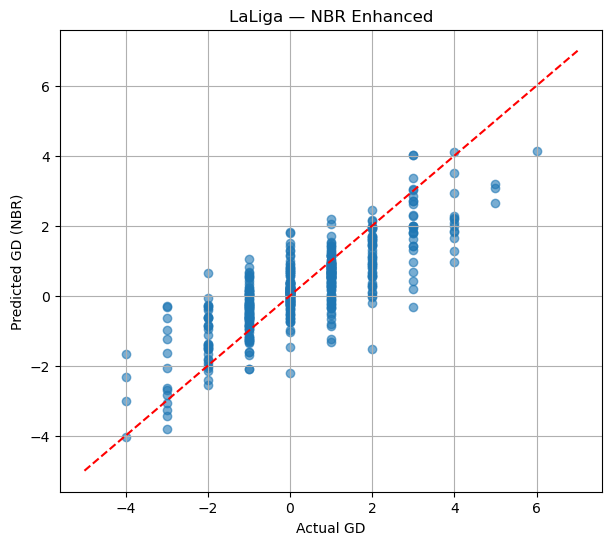

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import math

# =========================================================
# NB PMF
# =========================================================
def nb_pmf(k, mu, alpha, eps=1e-12):
    mu = max(mu, eps)
    alpha = max(alpha, eps)
    r = 1.0/alpha
    p = r/(r+mu)
    return math.exp(
        math.lgamma(k+r) - math.lgamma(r) - math.lgamma(k+1)
    ) * ((1-p)**k) * (p**r)

def expected_diff(mu_h, mu_a, ah, aa, max_goal=8):
    s = 0.0
    for gh in range(max_goal+1):
        ph = nb_pmf(gh, mu_h, ah)
        for ga in range(max_goal+1):
            pa = nb_pmf(ga, mu_a, aa)
            pij = ph*pa
            s += (gh - ga)*pij
    return s

# =========================================================
# NB2 FIT — robust
# =========================================================
def nb2_fit(X, y, alpha0=0.3, max_iter=200, tol=1e-6, lam=1e-4):
    X_ = np.column_stack([np.ones(len(X)), X])
    Z0 = np.log(y+1)

    A = X_.T @ X_ + lam*np.eye(X_.shape[1])
    b = X_.T @ Z0
    beta = pinv(A) @ b
    alpha = alpha0

    for _ in range(max_iter):
        eta = X_ @ beta
        mu = np.exp(eta)

        w = mu / (1 + alpha * mu)
        z = eta + (y - mu)/np.maximum(mu, 1e-12)

        WX = w[:,None] * X_
        H = X_.T @ WX + lam*np.eye(X_.shape[1])
        U = X_.T @ (w*(z-eta))

        beta_new = beta + pinv(H) @ U
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

        mu = np.exp(X_ @ beta)
        m = mu.mean()
        v = ((y - mu)**2).mean()
        alpha_new = max(1e-6, (v - m)/(m*m + 1e-12))
        if abs(alpha_new - alpha) < 1e-6:
            alpha = alpha_new
            break
        alpha = alpha_new

    return beta, alpha


# =========================================================
# STRENGTH
# =========================================================
def build_strength_split(df, lam=1e-4):
    h = df["HomeID"].values
    a = df["AwayID"].values
    teams = np.unique(np.concatenate([h,a]))
    n = len(teams)
    id2i = {t:i for i,t in enumerate(teams)}

    p = 1 + n + n
    m = len(df)*2
    X = np.zeros((m,p))
    y = np.zeros(m)

    r = 0
    for _,row in df.iterrows():
        hi = id2i[row["HomeID"]]
        ai = id2i[row["AwayID"]]

        X[r,0] = 1; X[r,1+hi] = 1; X[r,1+n+ai] = -1
        y[r] = row["FTHG"]; r += 1

        X[r,0] = 1; X[r,1+ai] = 1; X[r,1+n+hi] = -1
        y[r] = row["FTAG"]; r += 1

    A = X.T @ X + lam*np.eye(p)
    b = X.T @ y
    coef = pinv(A) @ b

    attack = coef[1:1+n]
    defend = coef[1+n:]
    attack -= attack.mean()
    defend -= defend.mean()

    return {teams[i]:float(attack[i]) for i in range(n)}, {teams[i]:float(defend[i]) for i in range(n)}

# =========================================================
# PREPROCESS
# =========================================================
def preprocess(df):
    df = df.copy()
    df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")

    df["HomeID"] = pd.to_numeric(df["home_id"], errors="coerce").astype("Int64")
    df["AwayID"] = pd.to_numeric(df["away_id"], errors="coerce").astype("Int64")
    df["FTHG"]   = pd.to_numeric(df["FTHG"], errors="coerce")
    df["FTAG"]   = pd.to_numeric(df["FTAG"], errors="coerce")

    df = df.dropna(subset=["HomeID","AwayID","FTHG","FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)
    df["GD"] = df["FTHG"] - df["FTAG"]
    return df.reset_index(drop=True)


# =========================================================
# LOAD
# =========================================================
df_raw = pd.read_excel("Data pertandingan19-25.xlsx")
df = preprocess(df_raw)

df = df.sort_index()

# Rolling form per HOME & AWAY
df["FormH"] = df.groupby("HomeID")["FTHG"].rolling(5,min_periods=1).mean().reset_index(level=0,drop=True)
df["FormA"] = df.groupby("AwayID")["FTAG"].rolling(5,min_periods=1).mean().reset_index(level=0,drop=True)

# Head-to-head (last 5)
df["H2H"] = (
    df.groupby(["HomeID","AwayID"])["GD"]
      .rolling(5,min_periods=1).mean()
      .reset_index(level=[0,1],drop=True)
)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

attH, defH = build_strength_split(df_train)

df_train["AtkH"] = df_train["HomeID"].map(attH)
df_train["DefA"] = df_train["AwayID"].map(defH)
df_train["AD"] = df_train["AtkH"] - df_train["DefA"]

df_test["AtkH"] = df_test["HomeID"].map(attH)
df_test["DefA"] = df_test["AwayID"].map(defH)
df_test["AD"] = df_test["AtkH"] - df_test["DefA"]

feat = ["AtkH","DefA","AD","FormH","FormA","H2H"]

df_train = df_train.fillna(0)
df_test  = df_test.fillna(0)

X   = df_train[feat].values
yH  = df_train["FTHG"].values
yA  = df_train["FTAG"].values

scaler = StandardScaler().fit(X)
Xstd = scaler.transform(X)

bh, ah = nb2_fit(Xstd, yH)
ba, aa = nb2_fit(Xstd, yA)


# =========================================================
# PREDICT
# =========================================================
def predict_nbr(dfX):
    d = dfX.copy()
    d["AtkH"] = d["HomeID"].map(attH)
    d["DefA"] = d["AwayID"].map(defH)
    d["AD"]   = d["AtkH"] - d["DefA"]

    X_ = scaler.transform(d[feat].values)
    Xh = np.column_stack([np.ones(len(X_)), X_])

    muH = np.exp(Xh @ bh)
    muA = np.exp(Xh @ ba)

    out = []
    for mh,ma in zip(muH,muA):
        ed = expected_diff(mh,ma,ah,aa)
        out.append(ed)

    out = np.array(out)
    return out   # TANPA tanh supaya tidak dipaksa sempit


pred = predict_nbr(df_test)
y_true = df_test["GD"].values

mae  = mean_absolute_error(y_true, pred)
mse  = mean_squared_error(y_true, pred)
rmse = np.sqrt(mse)
# --- Akurasi tanpa toleransi (exact match)
pred_round = np.round(pred)   # bulatkan ke integer
acc1 = (pred_round == y_true).mean() * 100
# acc1 = (np.abs(y_true - pred) <= 1).mean()*100

print("=== Evaluasi NBR Enhanced (Selisih Gol) ===")
print("MAE :", mae)
print("RMSE:", rmse)
print("Acc ±1 :", acc1, "%")

plt.figure(figsize=(7,6))
plt.scatter(y_true, pred, alpha=0.6)
xx = np.linspace(min(y_true)-1, max(y_true)+1, 200)
plt.plot(xx, xx, "r--")
plt.grid()
plt.xlabel("Actual GD")
plt.ylabel("Predicted GD (NBR)")
plt.title("LaLiga — NBR Enhanced")
plt.show()



=== Evaluasi NBR EPL (NO tolerance, exact GD) ===
Sumber prediksi : expectation
Shrink          : 1.20
Clip            : None
MAE             : 0.8086
RMSE            : 1.1137
Accuracy (exact): 45.11%


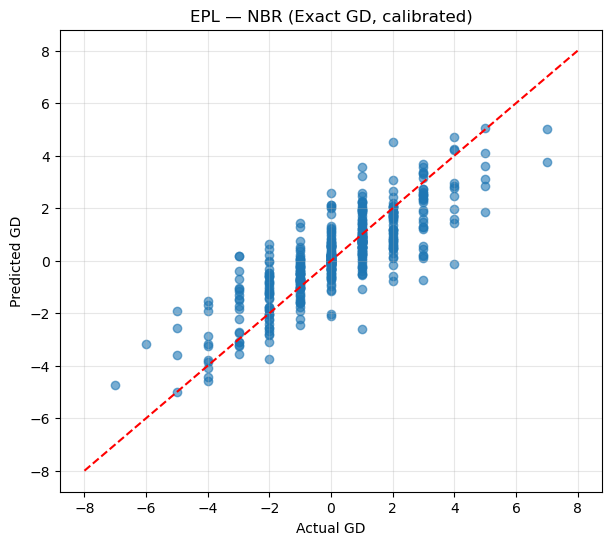

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import math


# =========================================================
# NB PMF
# =========================================================
def nb_pmf(k, mu, alpha, eps=1e-12):
    mu = max(mu, eps)
    alpha = max(alpha, eps)
    r = 1.0 / alpha
    p = r / (r + mu)
    return math.exp(
        math.lgamma(k+r) - math.lgamma(r) - math.lgamma(k+1)
    ) * ((1 - p) ** k) * (p ** r)


def expected_diff(mu_h, mu_a, ah, aa, max_goal=8):
    s = 0.0
    for gh in range(max_goal+1):
        ph = nb_pmf(gh, mu_h, ah)
        for ga in range(max_goal+1):
            pa = nb_pmf(ga, mu_a, aa)
            pij = ph * pa
            s += (gh - ga) * pij
    return s


# =========================================================
# NB2 FIT — robust
# =========================================================
def nb2_fit(X, y, alpha0=0.3, max_iter=200, tol=1e-6, lam=1e-4):
    X_ = np.column_stack([np.ones(len(X)), X])
    Z0 = np.log(y + 1)

    A = X_.T @ X_ + lam * np.eye(X_.shape[1])
    b = X_.T @ Z0
    beta = pinv(A) @ b
    alpha = alpha0

    for _ in range(max_iter):
        eta = X_ @ beta
        mu = np.exp(eta)

        w = mu / (1 + alpha * mu)
        z = eta + (y - mu) / np.maximum(mu, 1e-12)

        WX = w[:, None] * X_
        H = X_.T @ WX + lam * np.eye(X_.shape[1])
        U = X_.T @ (w * (z - eta))

        beta_new = beta + pinv(H) @ U
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

        mu = np.exp(X_ @ beta)
        m = mu.mean()
        v = ((y - mu) ** 2).mean()
        alpha_new = max(1e-6, (v - m) / (m*m + 1e-12))
        if abs(alpha_new - alpha) < 1e-6:
            alpha = alpha_new
            break
        alpha = alpha_new

    return beta, alpha


# =========================================================
# STRENGTH
# =========================================================
def build_strength_split(df, lam=1e-4):
    h = df["HomeID"].values
    a = df["AwayID"].values
    teams = np.unique(np.concatenate([h, a]))
    n = len(teams)
    id2i = {t: i for i, t in enumerate(teams)}

    p = 1 + n + n
    m = len(df) * 2
    X = np.zeros((m, p))
    y = np.zeros(m)

    r = 0
    for _, row in df.iterrows():
        hi = id2i[row["HomeID"]]
        ai = id2i[row["AwayID"]]

        X[r,0] = 1; X[r,1+hi] = 1; X[r,1+n+ai] = -1
        y[r]   = row["FTHG"];   r += 1

        X[r,0] = 1; X[r,1+ai] = 1; X[r,1+n+hi] = -1
        y[r]   = row["FTAG"];   r += 1

    A = X.T @ X + lam * np.eye(p)
    b = X.T @ y
    coef = pinv(A) @ b

    attack = coef[1:1+n]
    defend = coef[1+n:]
    attack -= attack.mean()
    defend -= defend.mean()

    return {teams[i]:float(attack[i]) for i in range(n)}, {teams[i]:float(defend[i]) for i in range(n)}


# =========================================================
# PREPROCESS
# =========================================================
def preprocess(df):
    df = df.copy()
    df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")

    df["HomeID"] = pd.to_numeric(df["home_id"], errors="coerce").astype("Int64")
    df["AwayID"] = pd.to_numeric(df["away_id"], errors="coerce").astype("Int64")
    df["FTHG"]   = pd.to_numeric(df["FTHG"], errors="coerce")
    df["FTAG"]   = pd.to_numeric(df["FTAG"], errors="coerce")

    df = df.dropna(subset=["HomeID", "AwayID", "FTHG", "FTAG"])
    df["HomeID"] = df["HomeID"].astype(int)
    df["AwayID"] = df["AwayID"].astype(int)
    df["GD"]     = df["FTHG"] - df["FTAG"]
    df["GD"]     = df["GD"].fillna(0)

    return df.reset_index(drop=True)


# =========================================================
# LOAD EPL DATA
# =========================================================
df_raw = pd.read_excel("epl_matches_with_ids.xlsx")
df = preprocess(df_raw)

df = df.sort_index()

df["FormH"] = df.groupby("HomeID")["FTHG"].rolling(5,min_periods=1).mean().reset_index(level=0,drop=True)
df["FormA"] = df.groupby("AwayID")["FTAG"].rolling(5,min_periods=1).mean().reset_index(level=0,drop=True)

df["H2H"] = (
    df.groupby(["HomeID","AwayID"])["GD"]
      .rolling(5,min_periods=1).mean()
      .reset_index(level=[0,1],drop=True)
)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

attH, defH = build_strength_split(df_train)

df_train["AtkH"] = df_train["HomeID"].map(attH)
df_train["DefA"] = df_train["AwayID"].map(defH)
df_train["AD"]   = df_train["AtkH"] - df_train["DefA"]

df_test["AtkH"] = df_test["HomeID"].map(attH)
df_test["DefA"] = df_test["AwayID"].map(defH)
df_test["AD"]   = df_test["AtkH"] - df_test["DefA"]

feat = ["AtkH","DefA","AD","FormH","FormA","H2H"]

df_train = df_train.fillna(0)
df_test  = df_test.fillna(0)

X   = df_train[feat].values
yH  = df_train["FTHG"].values
yA  = df_train["FTAG"].values

scaler = StandardScaler().fit(X)
Xstd   = scaler.transform(X)

bh, ah = nb2_fit(Xstd, yH)
ba, aa = nb2_fit(Xstd, yA)


# =========================================================
# CORE PREDICT
# =========================================================
def predict_core(dfX):
    d = dfX.copy()
    d["AtkH"] = d["HomeID"].map(attH)
    d["DefA"] = d["AwayID"].map(defH)
    d["AD"]   = d["AtkH"] - d["DefA"]

    X_ = scaler.transform(d[feat].values)
    Xh = np.column_stack([np.ones(len(X_)), X_])

    muH = np.exp(Xh @ bh)
    muA = np.exp(Xh @ ba)

    return muH, muA


def mode_diff(mu_h, mu_a, ah, aa, max_goal=8):
    best = 0
    bestp = -1
    for gh in range(max_goal+1):
        ph = nb_pmf(gh, mu_h, ah)
        for ga in range(max_goal+1):
            pa = nb_pmf(ga, mu_a, aa)
            pij = ph * pa
            if pij > bestp:
                bestp = pij
                best  = gh - ga
    return best


def predict_variants(dfX, max_goal=8):
    muH, muA = predict_core(dfX)
    ed = np.array([
        expected_diff(mh, ma, ah, aa, max_goal=max_goal)
        for mh,ma in zip(muH,muA)
    ])
    md = np.array([
        mode_diff(mh, ma, ah, aa, max_goal=max_goal)
        for mh,ma in zip(muH,muA)
    ])
    return ed, md


# =========================================================
# SPLIT CALIBRATION
# =========================================================
df_model, df_calib = train_test_split(df_train, test_size=0.2, random_state=42)

ed_cal, md_cal = predict_variants(df_calib, max_goal=8)

# handle NaN
ed_cal = np.nan_to_num(ed_cal, nan=0.0, posinf=0.0, neginf=0.0)
md_cal = np.nan_to_num(md_cal, nan=0.0, posinf=0.0, neginf=0.0)

y_cal = df_calib["GD"].values
y_cal = np.nan_to_num(y_cal, nan=0.0)


def evaluate_exact(y_true, y_pred_float, strategy="round", shrink=1.0, clip=None):
    x = y_pred_float * shrink
    if clip is not None:
        x = np.clip(x, -clip, clip)

    if strategy == "round":
        xp = np.round(x)
    else:
        xp = np.round(x)

    acc  = (xp == y_true).mean()
    mae  = mean_absolute_error(y_true, x)
    rmse = np.sqrt(mean_squared_error(y_true, x))
    return acc, mae, rmse, xp, x


best = {"acc": -1}

for who, base in [("expectation", ed_cal), ("mode", md_cal)]:
    for strategy in ["round"]:
        for shrink in np.linspace(0.6, 1.2, 13):
            for clip in [None, 1, 2, 3]:
                acc, mae, rmse, _, _ = evaluate_exact(y_cal, base, strategy, shrink, clip)
                if acc > best["acc"]:
                    best = {
                        "acc": acc,
                        "who": who,
                        "shrink": shrink,
                        "clip": clip,
                        "strategy": strategy
                    }


# =========================================================
# FINAL TEST
# =========================================================
ed_te, md_te = predict_variants(df_test, max_goal=8)

ed_te = np.nan_to_num(ed_te, nan=0.0, posinf=0.0, neginf=0.0)
md_te = np.nan_to_num(md_te, nan=0.0, posinf=0.0, neginf=0.0)

y_te = df_test["GD"].values
y_te = np.nan_to_num(y_te, nan=0.0)

base_te = ed_te if best["who"]=="expectation" else md_te

acc, mae, rmse, pred_int, pred_float = evaluate_exact(
    y_te,
    base_te,
    strategy=best["strategy"],
    shrink=best["shrink"],
    clip=best["clip"]
)

print("\n=== Evaluasi NBR EPL (NO tolerance, exact GD) ===")
print(f"Sumber prediksi : {best['who']}")
print(f"Shrink          : {best['shrink']:.2f}")
print(f"Clip            : {best['clip']}")
print(f"MAE             : {mae:.4f}")
print(f"RMSE            : {rmse:.4f}")
print(f"Accuracy (exact): {acc*100:.2f}%")

plt.figure(figsize=(7,6))
plt.scatter(y_te, pred_float, alpha=0.6)
xx = np.linspace(min(y_te)-1, max(y_te)+1, 200)
plt.plot(xx, xx, "r--")
plt.grid(alpha=0.3)
plt.xlabel("Actual GD")
plt.ylabel("Predicted GD")
plt.title("EPL — NBR (Exact GD, calibrated)")
plt.show()


In [10]:
# =========================================================
# 10 DATA — PREMATCH & HALF-TIME (EPL, NBR)
# =========================================================

# Pastikan kolom HT ada (kalau tidak ada di file, isi 0)
if "HTHG" not in df_test.columns: 
    df_test["HTHG"] = 0.0
if "HTAG" not in df_test.columns: 
    df_test["HTAG"] = 0.0

# Prediksi mu untuk seluruh df_test
muH_te, muA_te = predict_core(df_test)

# -------- PREMATCH: 10 sampel --------
df_pm = df_test.copy().reset_index(drop=True)
df_pm["mu_home"]   = muH_te
df_pm["mu_away"]   = muA_te
df_pm["exp_diff"]  = df_pm["mu_home"] - df_pm["mu_away"]
df_pm["true_diff"] = df_pm["GD"]

pm_out = df_pm.loc[:9, ["HomeID","AwayID","mu_home","mu_away","exp_diff","true_diff"]].round(3)

print("\n=== PREMATCH — 10 DATA (EPL, NBR) ===")
print(pm_out.to_string(index=False))

# -------- HALF-TIME: 10 sampel --------
df_ht = df_pm.loc[:9, ["HomeID","AwayID","HTHG","HTAG","mu_home","mu_away","true_diff"]].copy()
df_ht["HTHG"] = pd.to_numeric(df_ht["HTHG"], errors="coerce").fillna(0)
df_ht["HTAG"] = pd.to_numeric(df_ht["HTAG"], errors="coerce").fillna(0)

df_ht["mu_home_ht"]  = df_ht["mu_home"] + df_ht["HTHG"]
df_ht["mu_away_ht"]  = df_ht["mu_away"] + df_ht["HTAG"]
df_ht["exp_diff_ht"] = df_ht["mu_home_ht"] - df_ht["mu_away_ht"]

ht_out = df_ht[["HomeID","AwayID","HTHG","HTAG","mu_home_ht","mu_away_ht","exp_diff_ht","true_diff"]].round(3)

print("\n=== HALF-TIME — 10 DATA (EPL, NBR) ===")
print(ht_out.to_string(index=False))

# -------- OPSIONAL: evaluasi 10 sampel (kalau mau lihat cepat) --------
def _sign(x): 
    return 1 if x>0 else (0 if x==0 else -1)

# prematch
pm_mae  = np.mean(np.abs(pm_out["true_diff"].values - pm_out["exp_diff"].values))
pm_rmse = np.sqrt(np.mean((pm_out["true_diff"].values - pm_out["exp_diff"].values)**2))
pm_acc  = np.mean([_sign(a)==_sign(b) for a,b in zip(pm_out["true_diff"].values, pm_out["exp_diff"].values)])

# halftime
ht_mae  = np.mean(np.abs(ht_out["true_diff"].values - ht_out["exp_diff_ht"].values))
ht_rmse = np.sqrt(np.mean((ht_out["true_diff"].values - ht_out["exp_diff_ht"].values)**2))
ht_acc  = np.mean([_sign(a)==_sign(b) for a,b in zip(ht_out["true_diff"].values, ht_out["exp_diff_ht"].values)])

print("\n--- Quick Eval (10 sampel) ---")
print(f"Prematch  -> MAE: {pm_mae:.3f} | RMSE: {pm_rmse:.3f} | Acc sign: {pm_acc*100:.2f}%")
print(f"Half-time -> MAE: {ht_mae:.3f} | RMSE: {ht_rmse:.3f} | Acc sign: {ht_acc*100:.2f}%")



=== PREMATCH — 10 DATA (EPL, NBR) ===
 HomeID  AwayID  mu_home  mu_away  exp_diff  true_diff
      7       5    1.312    0.838     0.474          0
     26       8    0.426    3.690    -3.264         -4
      7       6    1.933    0.378     1.555          2
     17      28    1.357    1.183     0.174          0
     16      24    2.151    1.242     0.909          0
      2      22    1.437    0.854     0.583          0
      7       8    2.267    0.782     1.485          0
      7       2    1.860    1.374     0.486          0
     14      18    1.973    0.637     1.337          2
     28       4    1.166    1.070     0.096          2

=== HALF-TIME — 10 DATA (EPL, NBR) ===
 HomeID  AwayID  HTHG  HTAG  mu_home_ht  mu_away_ht  exp_diff_ht  true_diff
      7       5     1     0       2.312       0.838        1.474          0
     26       8     1     1       1.426       4.690       -3.264         -4
      7       6     1     0       2.933       0.378        2.555          2
     17     

In [8]:
# =========================================================
# ADD SEASON COLUMN
# =========================================================
def add_season(df):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    seasons=[]
    for d in df["Date"]:
        y,m = d.year, d.month
        if m >= 7:
            seasons.append(f"{y}/{y+1}")
        else:
            seasons.append(f"{y-1}/{y}")
    df["season"] = seasons
    return df


# =========================================================
# FIT MODEL PADA DATA TRAIN (tanpa season S)
# =========================================================
def train_model(df_train):
    df_train = df_train.copy()

    # strength
    att, deff = build_strength_split(df_train)
    df_train["AtkH"] = df_train["HomeID"].map(att)
    df_train["DefA"] = df_train["AwayID"].map(deff)
    df_train["AD"]   = df_train["AtkH"] - df_train["DefA"]

    # rolling
    df_train["FormH"] = df_train.groupby("HomeID")["FTHG"].rolling(5,1).mean().reset_index(level=0,drop=True)
    df_train["FormA"] = df_train.groupby("AwayID")["FTAG"].rolling(5,1).mean().reset_index(level=0,drop=True)
    df_train["H2H"] = df_train.groupby(["HomeID","AwayID"])["GD"].rolling(5,1).mean().reset_index(level=[0,1],drop=True)

    df_train = df_train.fillna(0)

    # features
    X   = df_train[["AtkH","DefA","AD","FormH","FormA","H2H"]].values
    yH  = df_train["FTHG"].values
    yA  = df_train["FTAG"].values

    scaler = StandardScaler().fit(X)
    Xstd   = scaler.transform(X)

    bh, ah = nb2_fit(Xstd, yH)
    ba, aa = nb2_fit(Xstd, yA)

    return bh, ah, ba, aa, scaler, att, deff


# =========================================================
# PREDICT MODEL PADA DATA TEST (musim S)
# =========================================================
def test_model(df_test, bh, ah, ba, aa, scaler, att, deff):
    d = df_test.copy()

    # strength map dari train
    d["AtkH"] = d["HomeID"].map(att)
    d["DefA"] = d["AwayID"].map(deff)
    d["AD"]   = d["AtkH"] - d["DefA"]

    # rolling test hanya pakai data test (tanpa leak)
    d["FormH"] = d.groupby("HomeID")["FTHG"].rolling(5,1).mean().reset_index(level=0,drop=True)
    d["FormA"] = d.groupby("AwayID")["FTAG"].rolling(5,1).mean().reset_index(level=0,drop=True)
    d["H2H"] = d.groupby(["HomeID","AwayID"])["GD"].rolling(5,1).mean().reset_index(level=[0,1],drop=True)
    d = d.fillna(0)

    # fitur
    X = d[["AtkH","DefA","AD","FormH","FormA","H2H"]].values
    Xstd = scaler.transform(X)

    Xh = np.column_stack([np.ones(len(Xstd)), Xstd])

    muH = np.exp(Xh @ bh)
    muA = np.exp(Xh @ ba)

    # expected GD
    pred = np.array([
        expected_diff(mh, ma, ah, aa)
        for mh,ma in zip(muH,muA)
    ])

    y_true = d["GD"].values

    mae  = mean_absolute_error(y_true, pred)
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    acc  = (np.round(pred) == y_true).mean()

    return mae, rmse, acc, pred


# =========================================================
# LOSO — Leave-One-Season-Out Evaluation
# =========================================================
df_season = add_season(df)

all_seasons = sorted(df_season["season"].unique())

summary = []

print("\n=== LOSO EVALUATION (VALID NO-LEAK SCRAPING) ===")

for S in all_seasons:

    df_train = df_season[df_season["season"] != S]
    df_test  = df_season[df_season["season"] == S]

    bh, ah, ba, aa, scaler, att, deff = train_model(df_train)

    mae, rmse, acc, pred = test_model(df_test, bh, ah, ba, aa, scaler, att, deff)

    print(f"\nSeason {S} — N={len(df_test)}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  Acc  : {acc*100:.2f}%")

    summary.append([S, len(df_test), mae, rmse, acc])

summary = pd.DataFrame(summary, columns=["Season","N","MAE","RMSE","ACC"])

print("\n=== RINGKASAN PER MUSIM ===")
print(summary)

print("\n=== TOTAL (RATA-RATA 6 MUSIM) ===")
print(f"MAE  : {summary['MAE'].mean():.4f}")
print(f"RMSE : {summary['RMSE'].mean():.4f}")
print(f"ACC  : {summary['ACC'].mean()*100:.2f}%")



=== LOSO EVALUATION (VALID NO-LEAK SCRAPING) ===

Season 2019/2020 — N=314
  MAE  : 0.4331
  RMSE : 0.8846
  Acc  : 73.25%

Season 2020/2021 — N=446
  MAE  : 0.4916
  RMSE : 0.7591
  Acc  : 64.57%

Season 2021/2022 — N=380
  MAE  : 0.4926
  RMSE : 0.8299
  Acc  : 66.05%

Season 2022/2023 — N=380
  MAE  : 0.4426
  RMSE : 0.7810
  Acc  : 67.11%

Season 2023/2024 — N=380
  MAE  : 0.4436
  RMSE : 0.8377
  Acc  : 72.63%

Season 2024/2025 — N=350
  MAE  : 0.3989
  RMSE : 0.6707
  Acc  : 73.71%

=== RINGKASAN PER MUSIM ===
      Season    N       MAE      RMSE       ACC
0  2019/2020  314  0.433053  0.884589  0.732484
1  2020/2021  446  0.491643  0.759065  0.645740
2  2021/2022  380  0.492603  0.829912  0.660526
3  2022/2023  380  0.442628  0.781041  0.671053
4  2023/2024  380  0.443556  0.837715  0.726316
5  2024/2025  350  0.398922  0.670695  0.737143

=== TOTAL (RATA-RATA 6 MUSIM) ===
MAE  : 0.4504
RMSE : 0.7938
ACC  : 69.55%


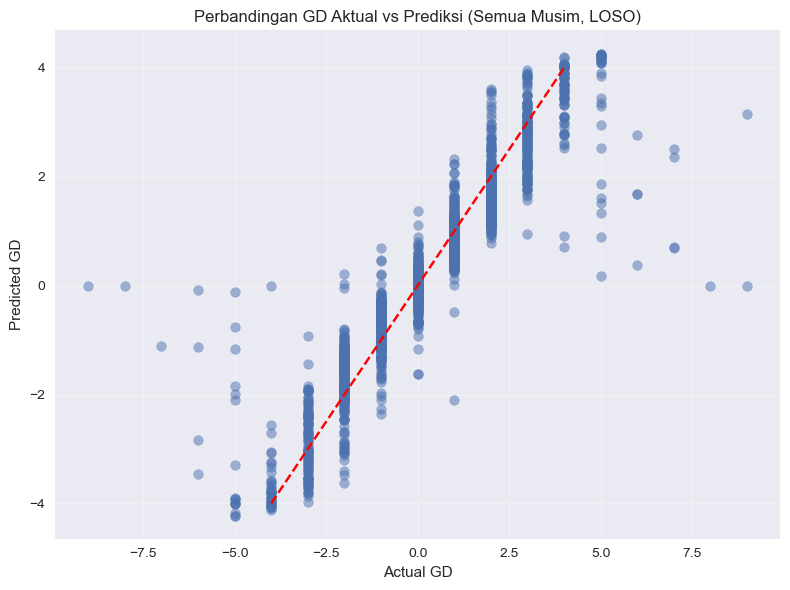

In [10]:
# =========================================================
# GRAFIK PERBANDINGAN GD — ALL SEASONS
# =========================================================
all_actual = []
all_pred = []

for S in all_seasons:
    df_train = df_season[df_season["season"] != S]
    df_test  = df_season[df_season["season"] == S]

    bh, ah, ba, aa, scaler, att, deff = train_model(df_train)
    mae, rmse, acc, pred = test_model(df_test, bh, ah, ba, aa, scaler, att, deff)

    all_actual.extend(df_test["GD"].values)
    all_pred.extend(pred)

plt.figure(figsize=(8,6))
plt.scatter(all_actual, all_pred, alpha=0.5)
plt.plot([-4,4], [-4,4], "r--")  # diagonal perfect line
plt.title("Perbandingan GD Aktual vs Prediksi (Semua Musim, LOSO)")
plt.xlabel("Actual GD")
plt.ylabel("Predicted GD")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
import numpy as np

actual = np.array(all_actual)
pred = np.array(all_pred)

# jarak vertikal ke garis diagonal y=x
distance = np.abs(pred - actual)

benar = distance < 0.5
salah = distance >= 0.5

print("Akurasi visual scatter = ", benar.mean() * 100)


Akurasi visual scatter =  69.24444444444444
